<div style="text-align: center;">
  <img src="https://github.com/Hack-io-Data/Imagenes/blob/main/01-LogosHackio/logo_naranja@4x.png?raw=true" alt="esquema" />
</div>


# Laboratorio de Gestión de Outliers

AutoRenew, la empresa líder en la venta de coches de segunda mano, sigue adelante con el desarrollo del modelo predictivo que ayudará a estimar el precio de los vehículos usados. Este modelo es clave para mejorar las estrategias de ventas, marketing y optimización del inventario de la empresa. Ya has realizado un análisis exploratorio inicial y gestionado los valores nulos en el conjunto de datos. Ahora, es el momento de abordar otro aspecto crucial del preprocesamiento: la **gestión de outliers**.

En este laboratorio, te enfocarás en identificar y gestionar los outliers (valores atípicos) presentes en el conjunto de datos. Los outliers pueden distorsionar los resultados de un análisis y afectar negativamente el rendimiento de los modelos predictivos, por lo que es fundamental tratarlos adecuadamente antes de proceder con las siguientes fases del proyecto.


**Instrucciones:**

1. **Identificación de Outliers:** Explora las columnas clave del conjunto de datos (como `price`, `powerCV`, `kilometer`, etc.) para identificar posibles outliers. Utiliza gráficos como diagramas de caja (boxplots) y análisis estadísticos para detectar valores que se desvíen significativamente del resto de los datos.

2. **Análisis de Outliers:** Una vez identificados, analiza los outliers para determinar si son errores de datos, valores extremos válidos o resultados de condiciones específicas que deben ser tenidos en cuenta. Considera el contexto de cada columna al evaluar la relevancia de estos valores atípicos.

3. **Gestión de Outliers:** Decide la estrategia más adecuada para manejar los outliers. Esto podría incluir la eliminación de los outliers, la transformación de los datos, o la aplicación de técnicas de imputación. Justifica tu elección basándote en cómo los outliers podrían afectar el modelo predictivo.

**Nota:** Recuerda que este laboratorio es parte de una serie de actividades en las que utilizarás el mismo conjunto de datos a lo largo de la semana. Documenta cuidadosamente los pasos que sigas para que puedas referirte a ellos en las próximas etapas del proyecto.


---

### **Importante**

En el análisis exploratorio inicial ya habíamos hecho una gestión de algunos outliers que habíamos considerado errores en nuestro conjunto de datos. Sin embargo, proseguiremos igualmente con los datos que tenemos por si queremos llevar a cabo alguna gestión adicional

In [2]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import numpy as np
import pandas as pd

# Otros objetivos
# -----------------------------------------------------------------------
import math

# Gráficos
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt


# Métodos estadísticos
# -----------------------------------------------------------------------
from scipy.stats import zscore # para calcular el z-score
from sklearn.neighbors import LocalOutlierFactor # para detectar outliers usando el método LOF
from sklearn.ensemble import IsolationForest # para detectar outliers usando el metodo IF
from sklearn.neighbors import NearestNeighbors # para calcular la epsilon

# Para generar combinaciones de listas
# -----------------------------------------------------------------------
from itertools import product, combinations

# Gestionar warnings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings('ignore')

from src.soporte_outliers import GestionOutliersMultivariados, GestionOutliersUnivariados

In [3]:
df = pd.read_csv('datos/autorenew_knn_escalado.csv', index_col=0)

# Por si acaso, aunque no hace nada aquí
df.reset_index(drop=True, inplace=True)

# Como algunas variables se cargan como numéricas las devolvemos a objeto
df['monthOfRegistration'] = df['monthOfRegistration'].astype(object)

### Identificación visual

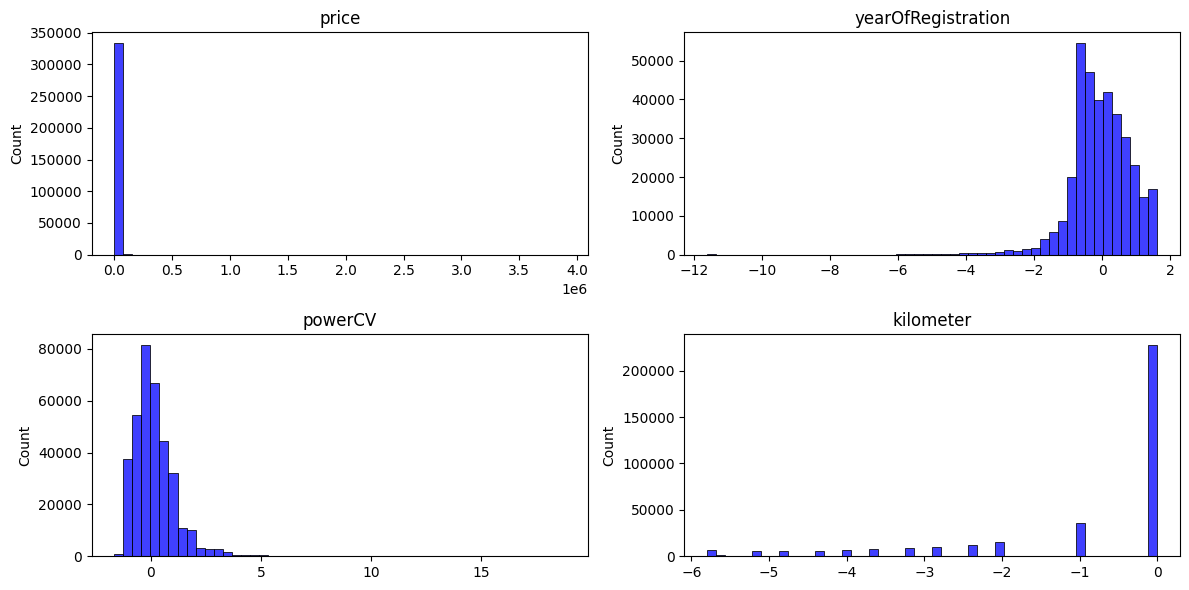

In [4]:
# Instanciamos la clase que nos permite identificar y gestionar outliers
gestion = GestionOutliersUnivariados(df)

# Llamamos al método que nos permite identificar outliers univariados de forma visual (hist)
gestion.visualizar_outliers_univariados(tipo_grafica="H", tamano_grafica=(12, 6))

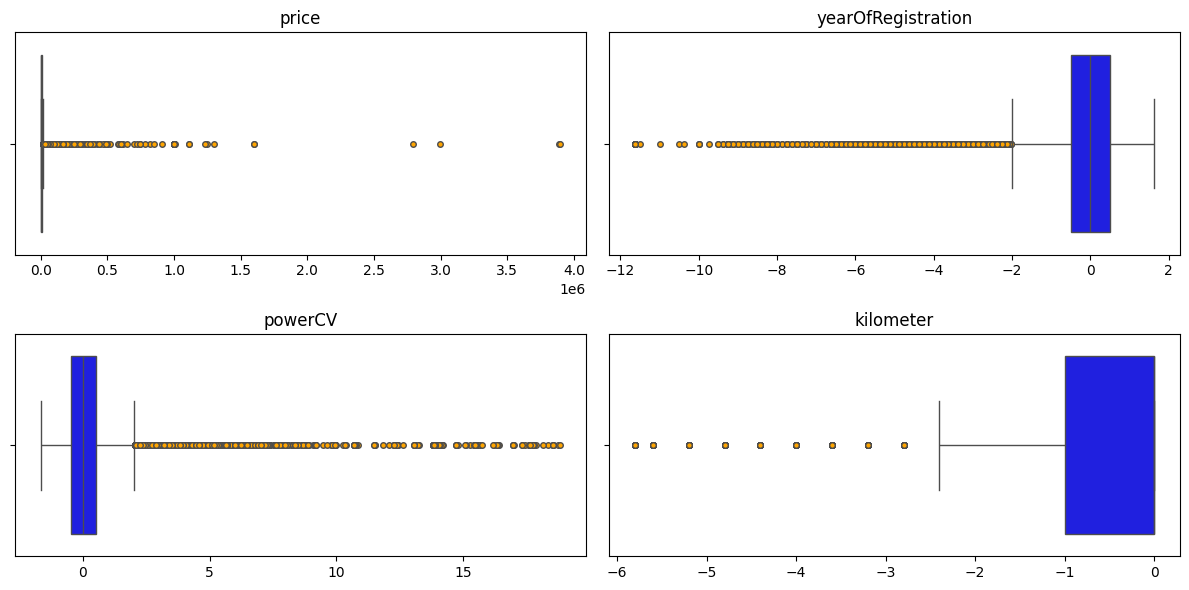

In [5]:
# Llamamos al método que nos permite identificar outliers univariados de forma visual (boxplot)
gestion.visualizar_outliers_univariados(tipo_grafica="B", tamano_grafica=(12, 6))

Vemos que tenemos una distribución de outliers similar a la vista en el análisis exploratorio. Hay muchos outliers en todas las categorías numéricas debido a la distribución asimétrica de las mismas:

* `Precio`: La mayoría de vehículos de segunda mano son "baratos" pero puede haber algunas entradas que se correspondan con vehículos de lujo que pueden tener un precio superior.

* `Año`: La mayoría de vehículos se corresponden con las últimas décadas, sin embargo pueden existir en el mercado algunos modelos históricos que tengan más antigüedad. Como el límite es el presente, ya que no puede haber vehículos del futuro (de momento 😉).

* `Potencia`: La mayoría de vehículos tienen una potencia estándar, pero algunos modelos pueden ser más potentes por ser vehículos deportivos de lujo u otro tipos de vehículos de mayor tamaño.

* `Kilómetros`: En este caso ya habíamos concluido que las entradas están agrupadas según ciertos valores discretos. La mayoría de vehículos están etiquetados con los números de kilómetros más altos, aunque hay algunas excepciones, que se corresponden con las entradas discretas que podemos ver en el diagrama.

---

### Identificación mediante IQR

In [6]:
outliers_iqr = gestion.detectar_outliers_iqr()

La cantidad de outliers que tenemos para la columna PRICE es 25568
La cantidad de outliers que tenemos para la columna YEAROFREGISTRATION es 7352
La cantidad de outliers que tenemos para la columna POWERCV es 13149
La cantidad de outliers que tenemos para la columna KILOMETER es 60922


In [7]:
df.shape[0]

352487

Como hemos visto en los histogramas y boxplot las distribuciones no son normales por lo que no tiene mucho sentido hacer un zscore

---

### Outliers multivariados

Vamos a hacer un análisis multivariado de los outliers para ver si podemos sacar alguna conclusión adicional.

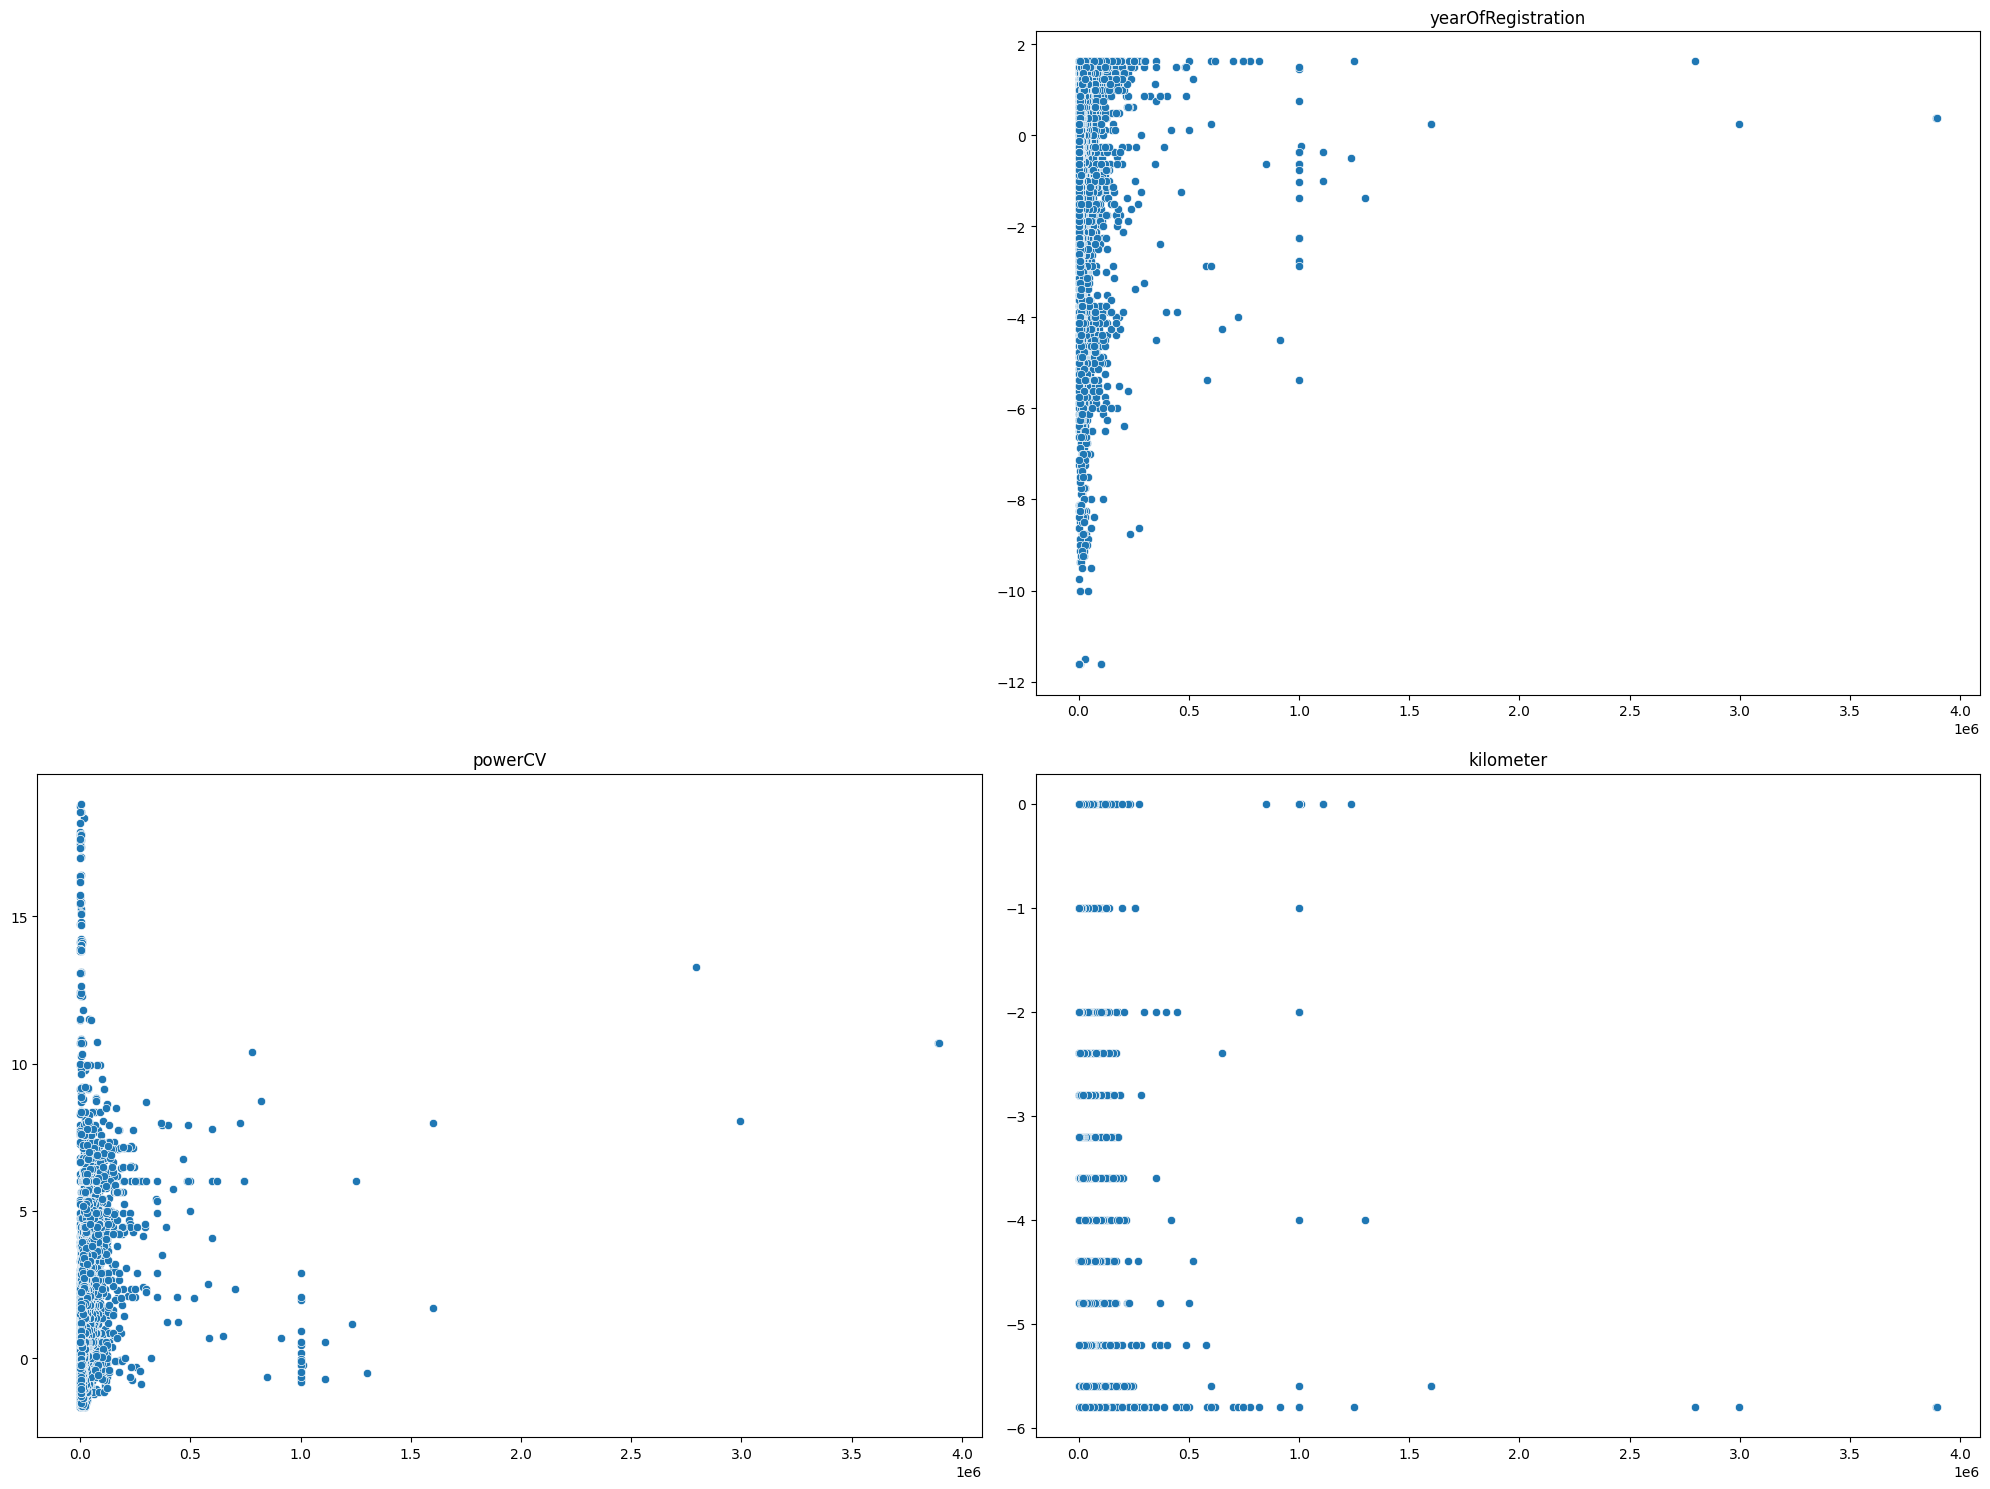

In [8]:
# Instanciamos la clase de indentificación de Outliers Multivariados
gestion_multi= GestionOutliersMultivariados(df)

# Llamamos al método que nos permite identificar los outliers
gestion_multi.visualizar_outliers_bivariados("price")

* Los valores atípicos de `powerCV` se acumulan en el rango de precios bajo, lo cual puede ser indicativo de presencia de vehículos de mayor tamaño o más potentes y no necesariamente de lujo. Por su parte los atípicos de `price` sí se distribuyen en un gran rango de potencias excluyendo valores elevados, lo cual puede sugerir datos erróneos o bien vehículos de lujo sin una potencia extraordinaria.

* En el caso de los `kilometer` sí parece que los vehículos más caros tienen menos km, salvo valores aislados que podríamos considerar verdaderamente atípicos, ya que es raro que un vehículo de segunda mano muy caro tenga muchos kilómetros. Sin embargo, podría tratarse de vehículos de lujo históricos o de coleccionismo.

* De todas formas, en el `yearOfRegistration` comprobamos que los precios extremadamente altos se corresponden con coches más nuevos, mientras que los excesivamente antiguos no poseen entradas de precios elevadas, lo cual debilita la suposición anterior.

---

Como no podemos tener nulos, vamos a hacer el análisis filtrando sus entradas de la variable respuesta. Recordemos que el precio no tenía nulos pero habíamos establecido un criterio para valores que no tenían sentido, es decir, ya habíamos hecho una gestión manual de outliers en el EDA teniendo en cuenta el contexto del problema.

Considerando esto, simplemente vamos a eliminar esos nulos introducidos artificialmente ya que son valores erróneos que no queremos que contaminen nuestro posterior análisis.

In [9]:
df.dropna(subset=['price'], inplace=True)

### Local outlier factor

In [10]:
indice_contaminacion=[0.01, 0.05, 0.1]
vecinos=[30, 60, 80]

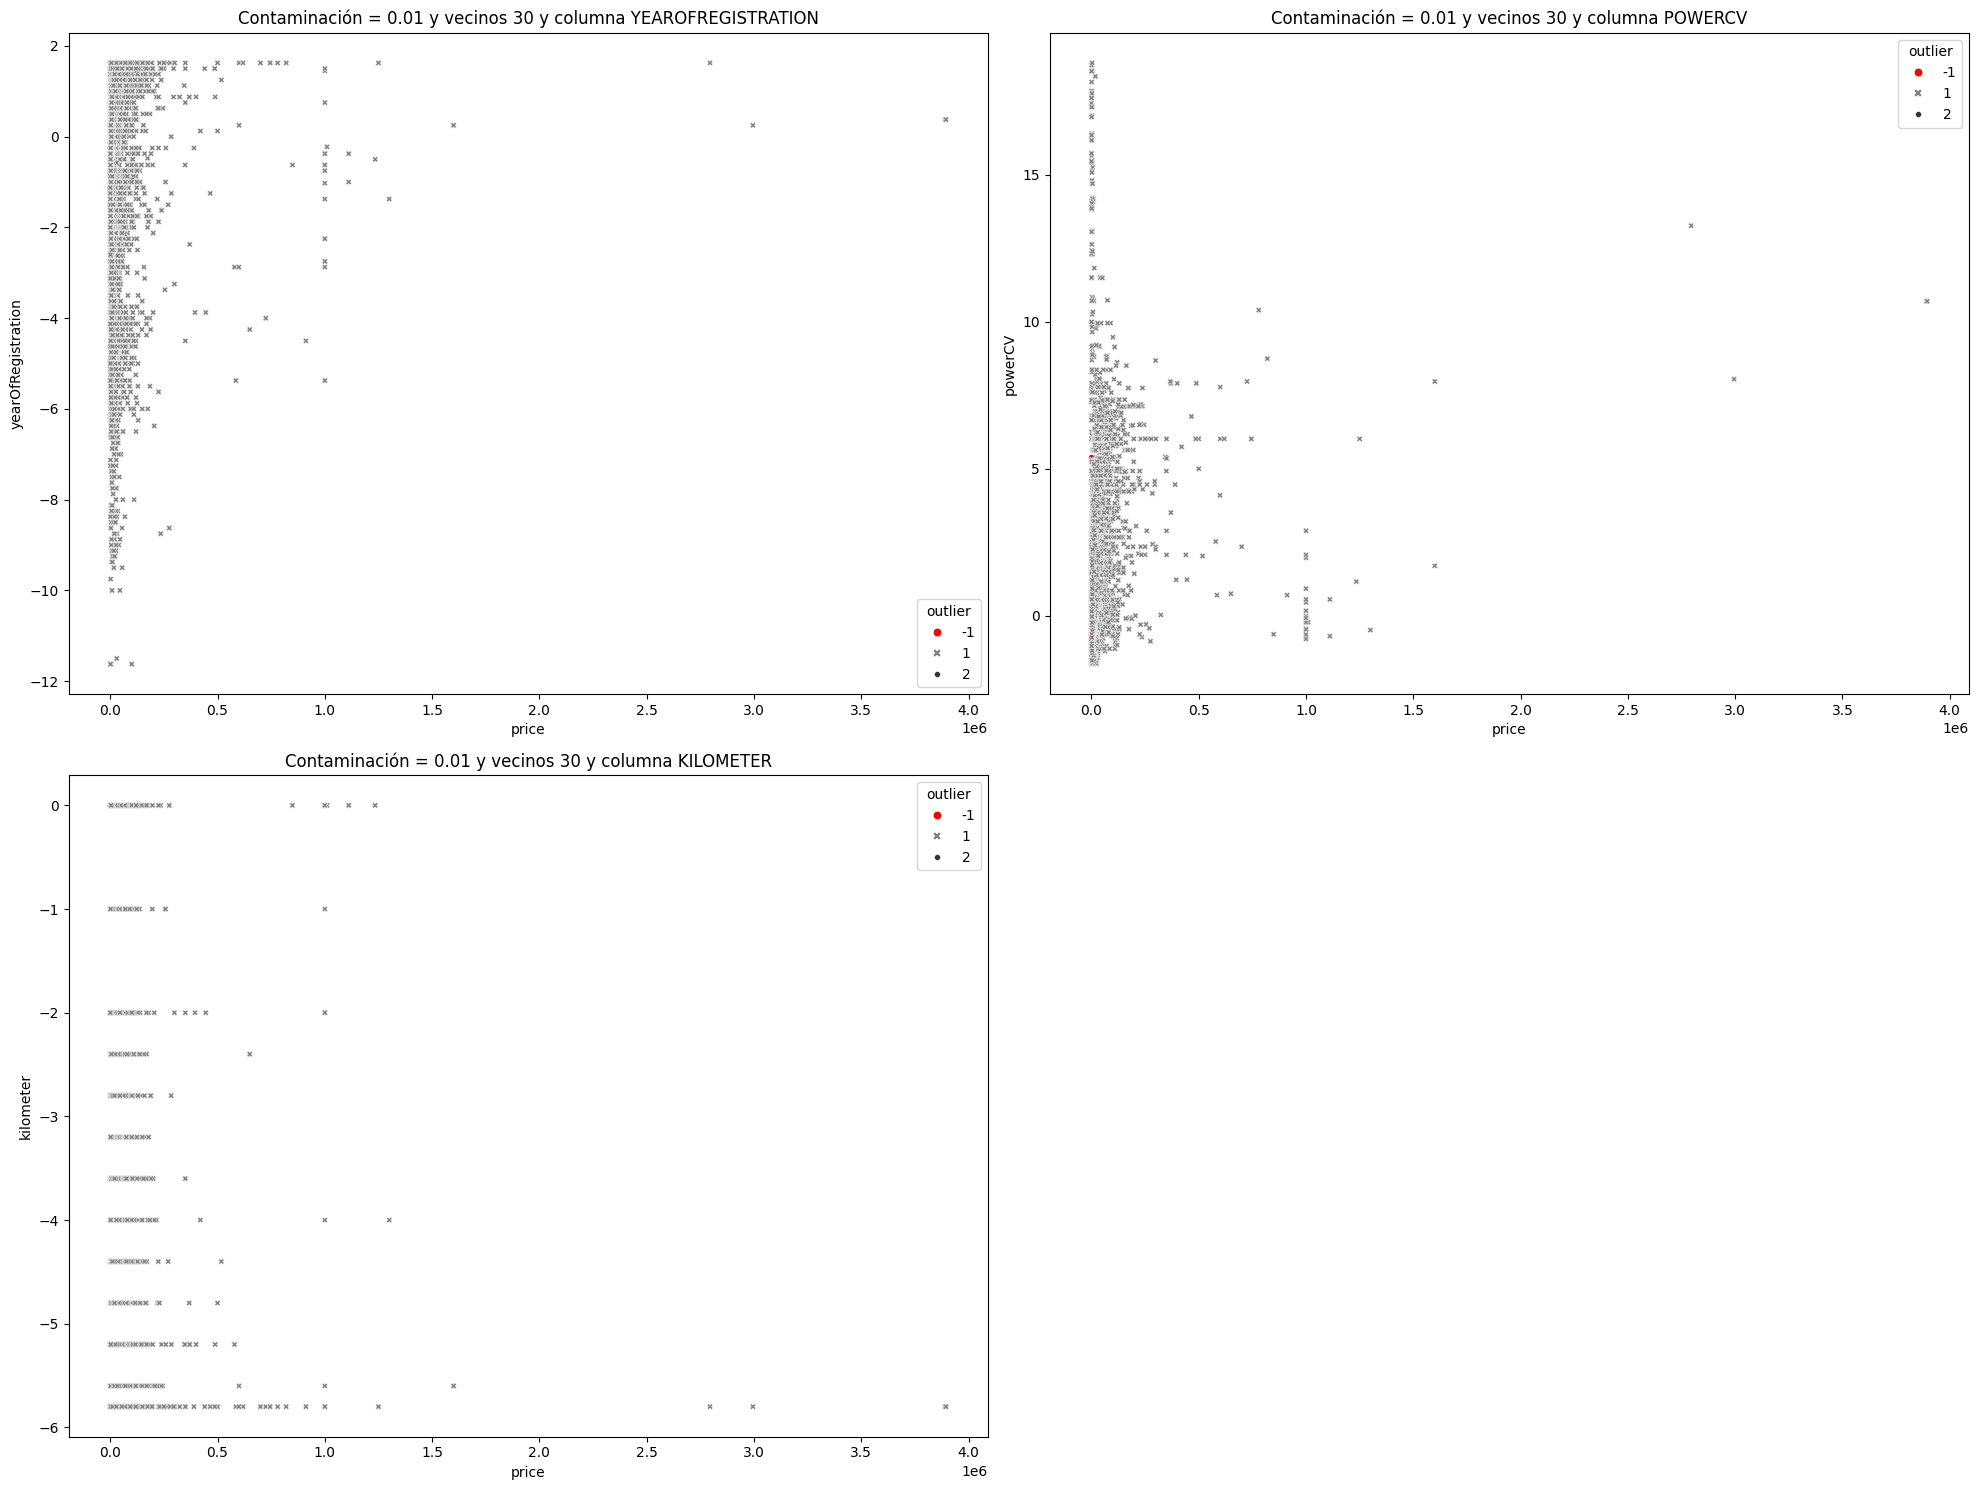

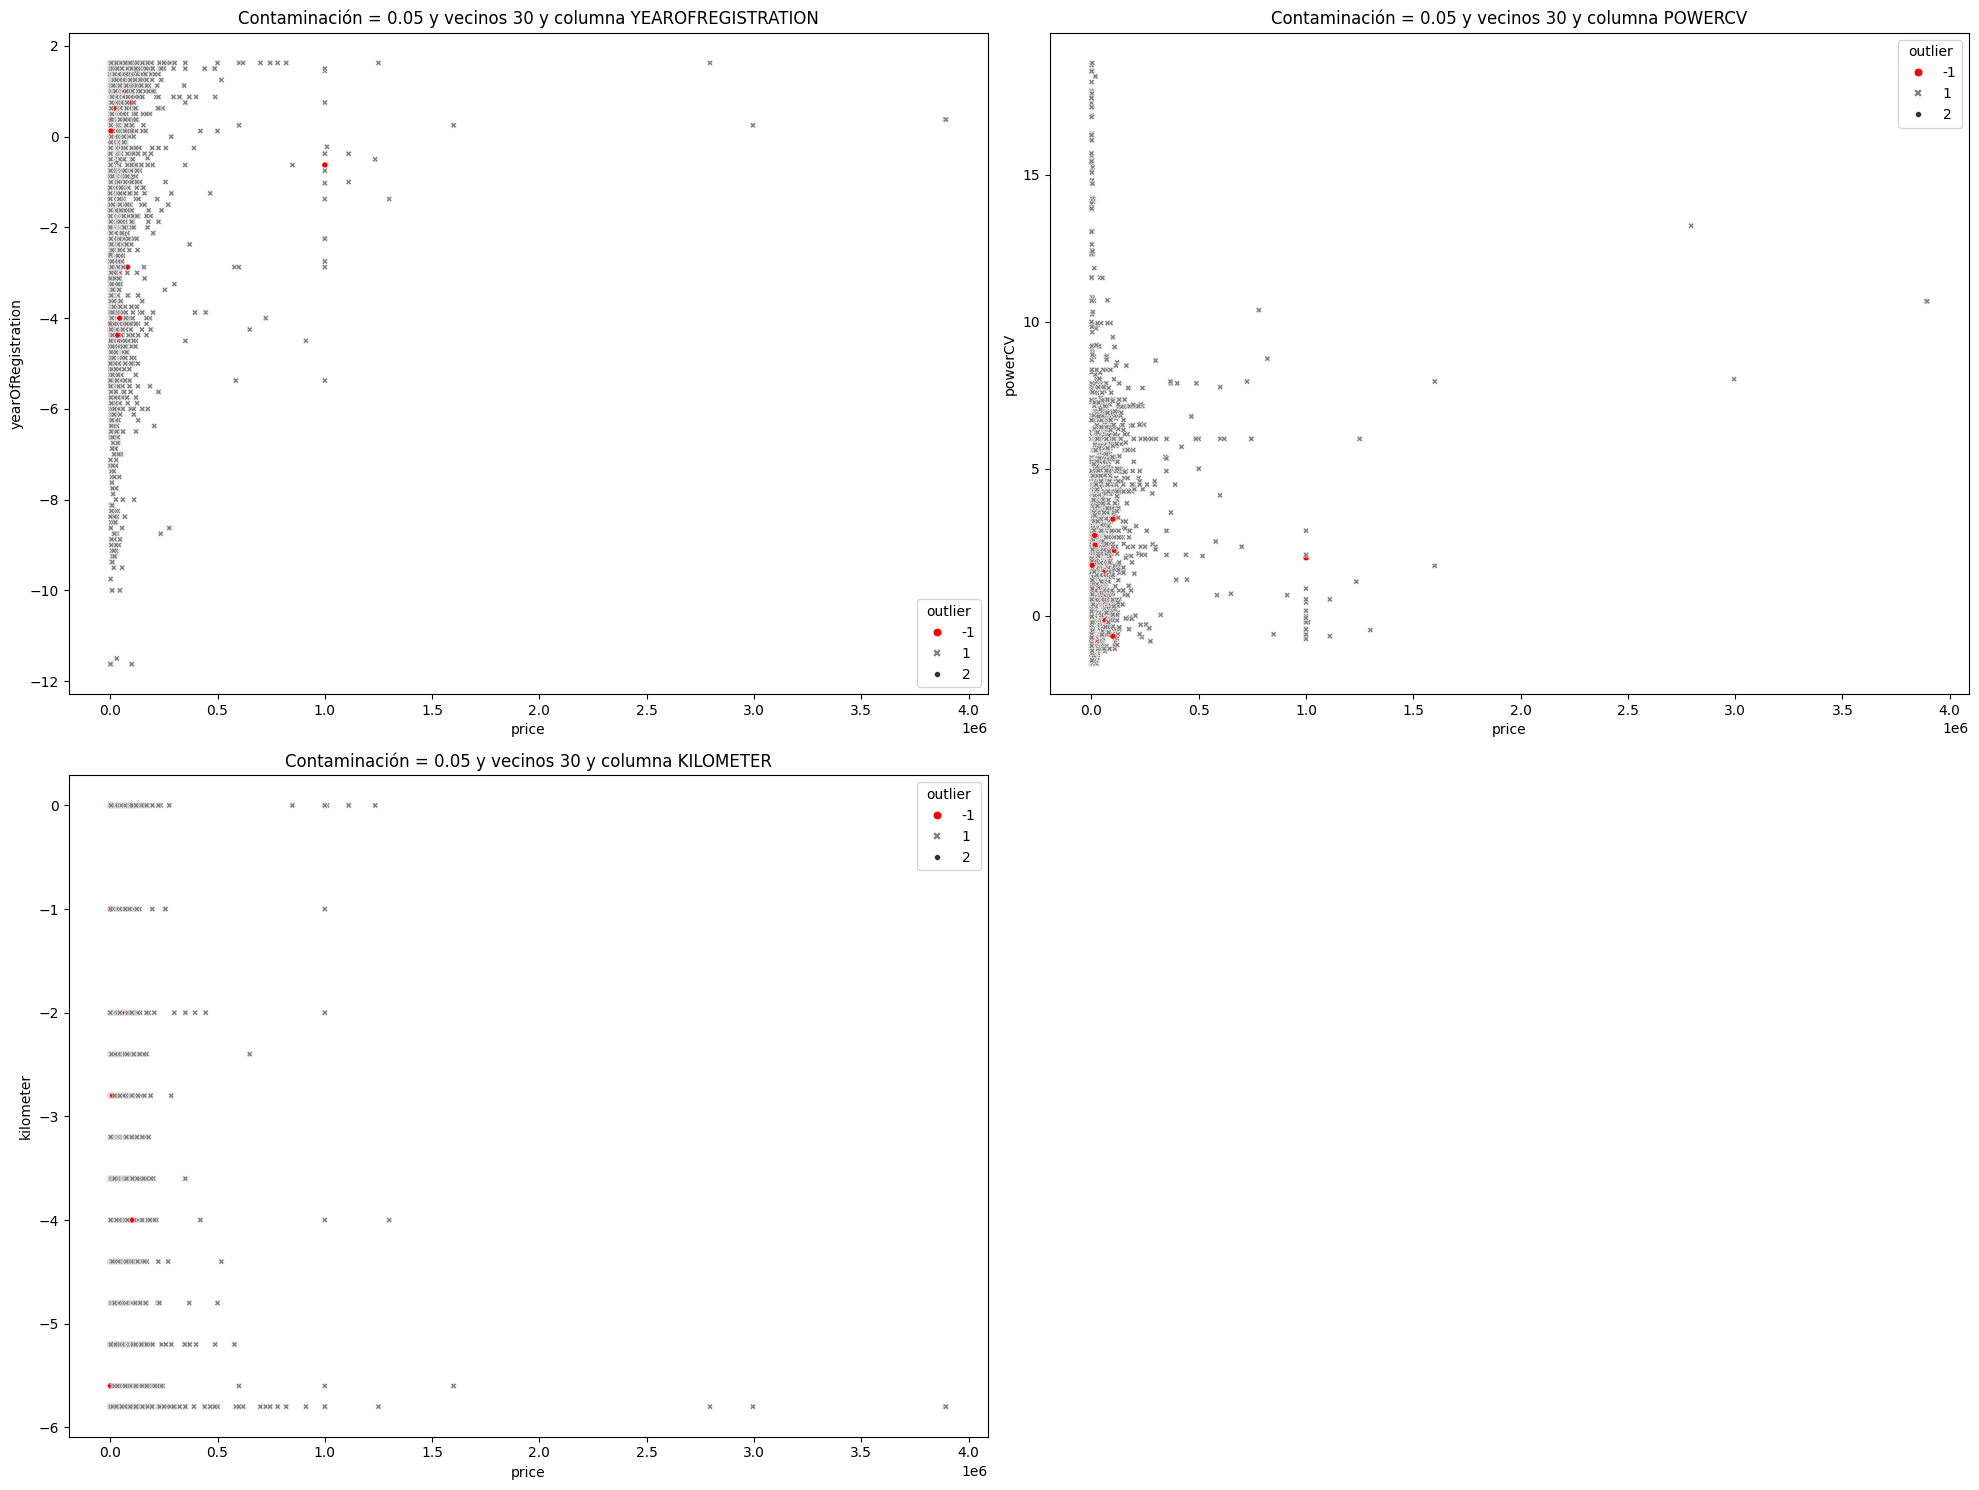

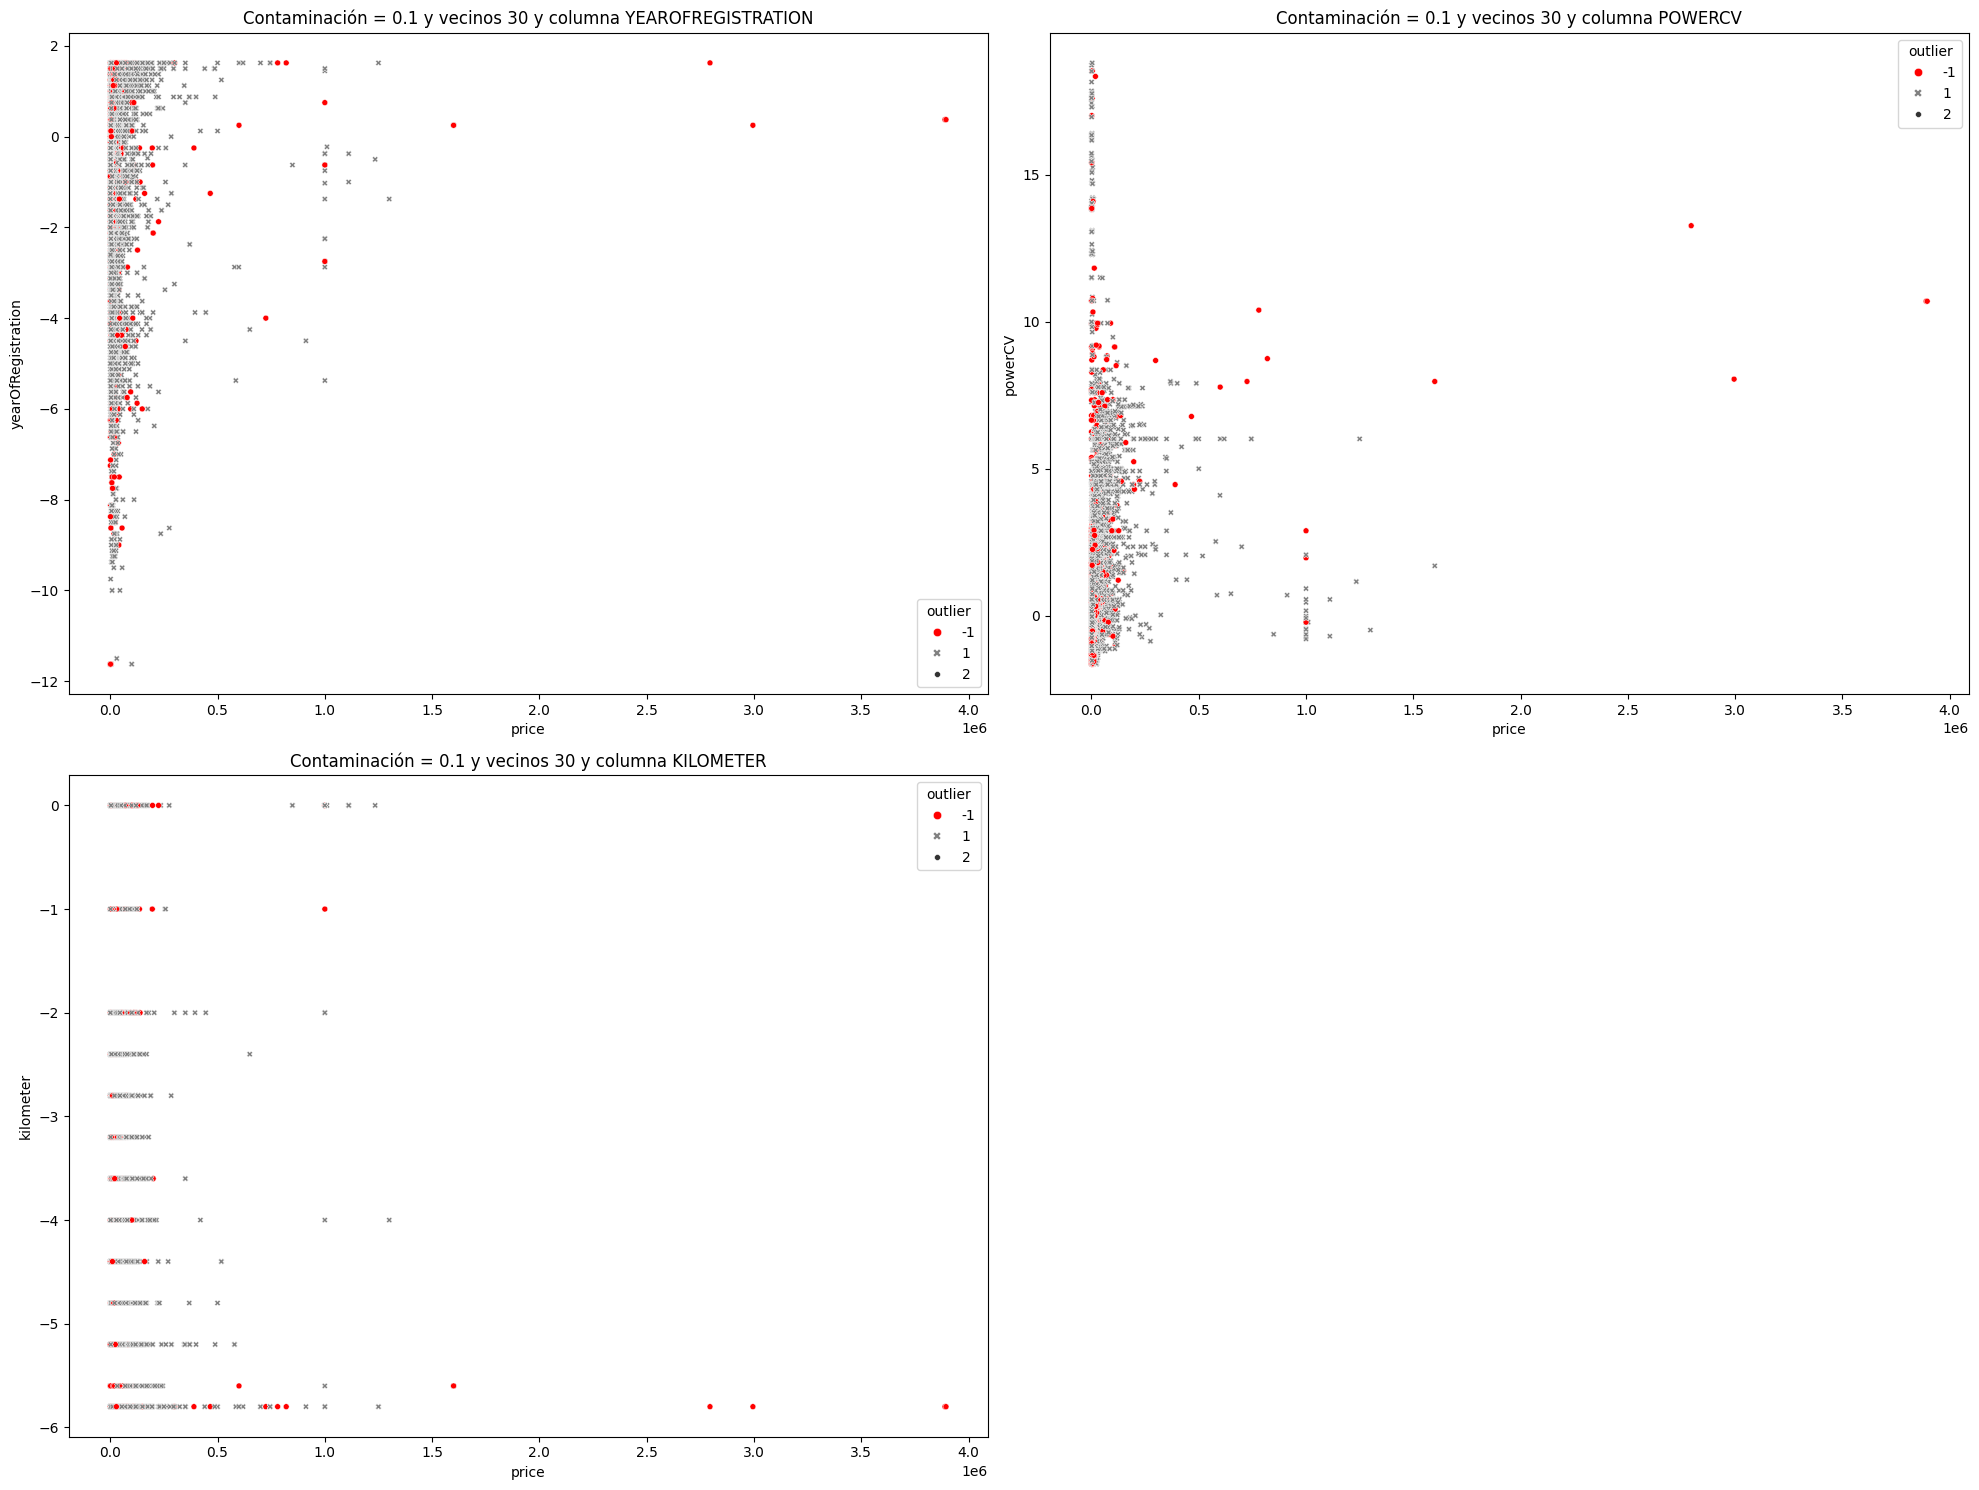

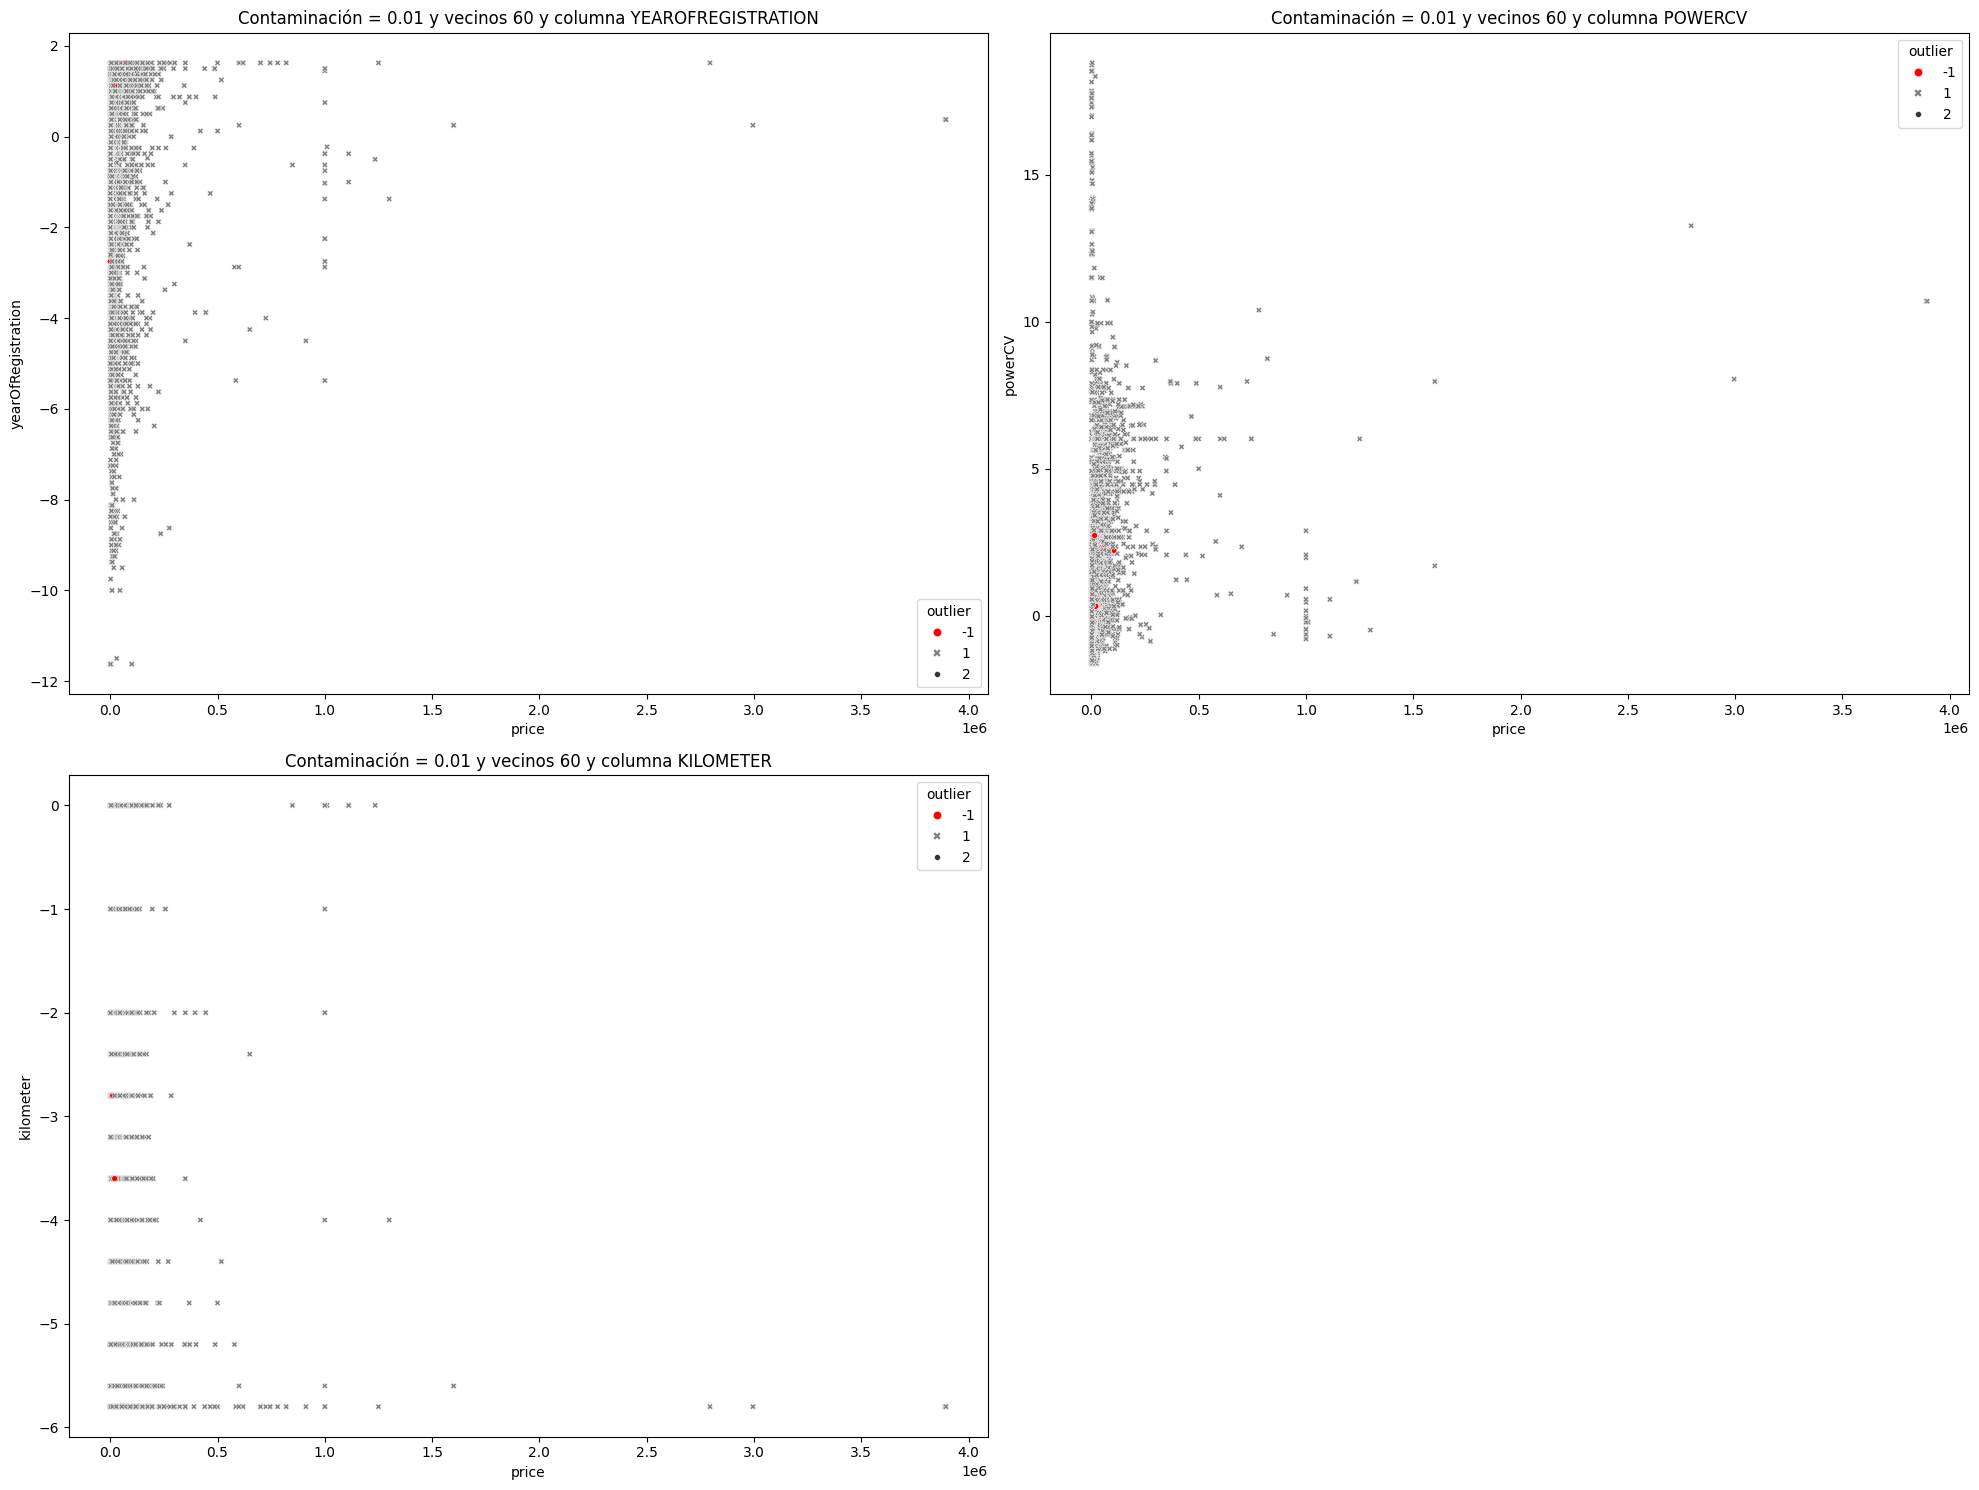

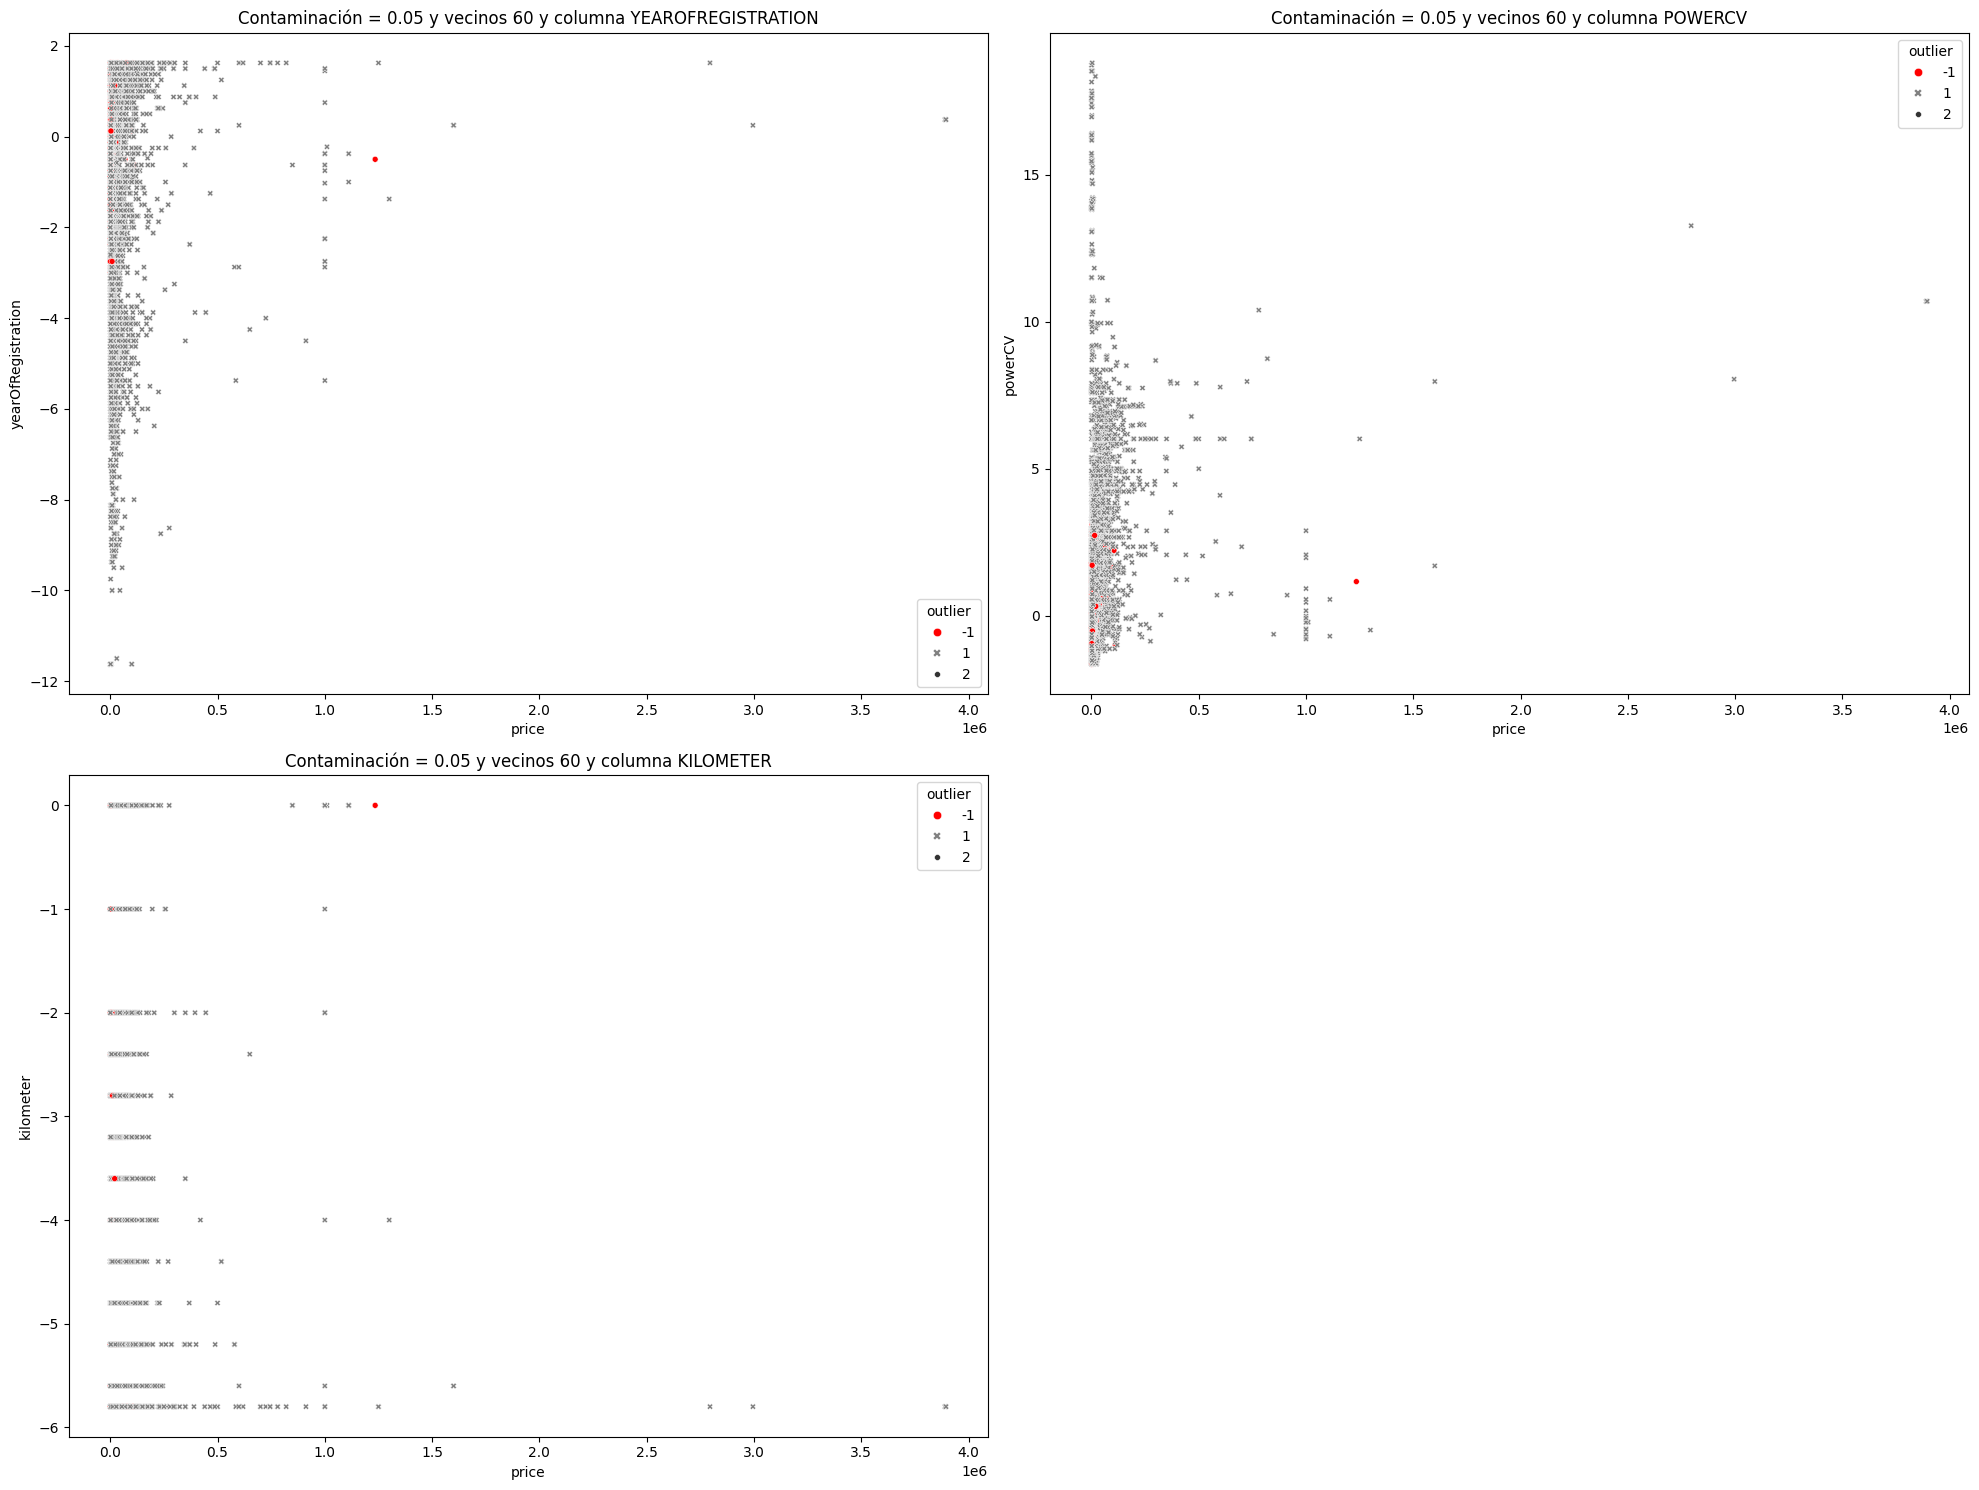

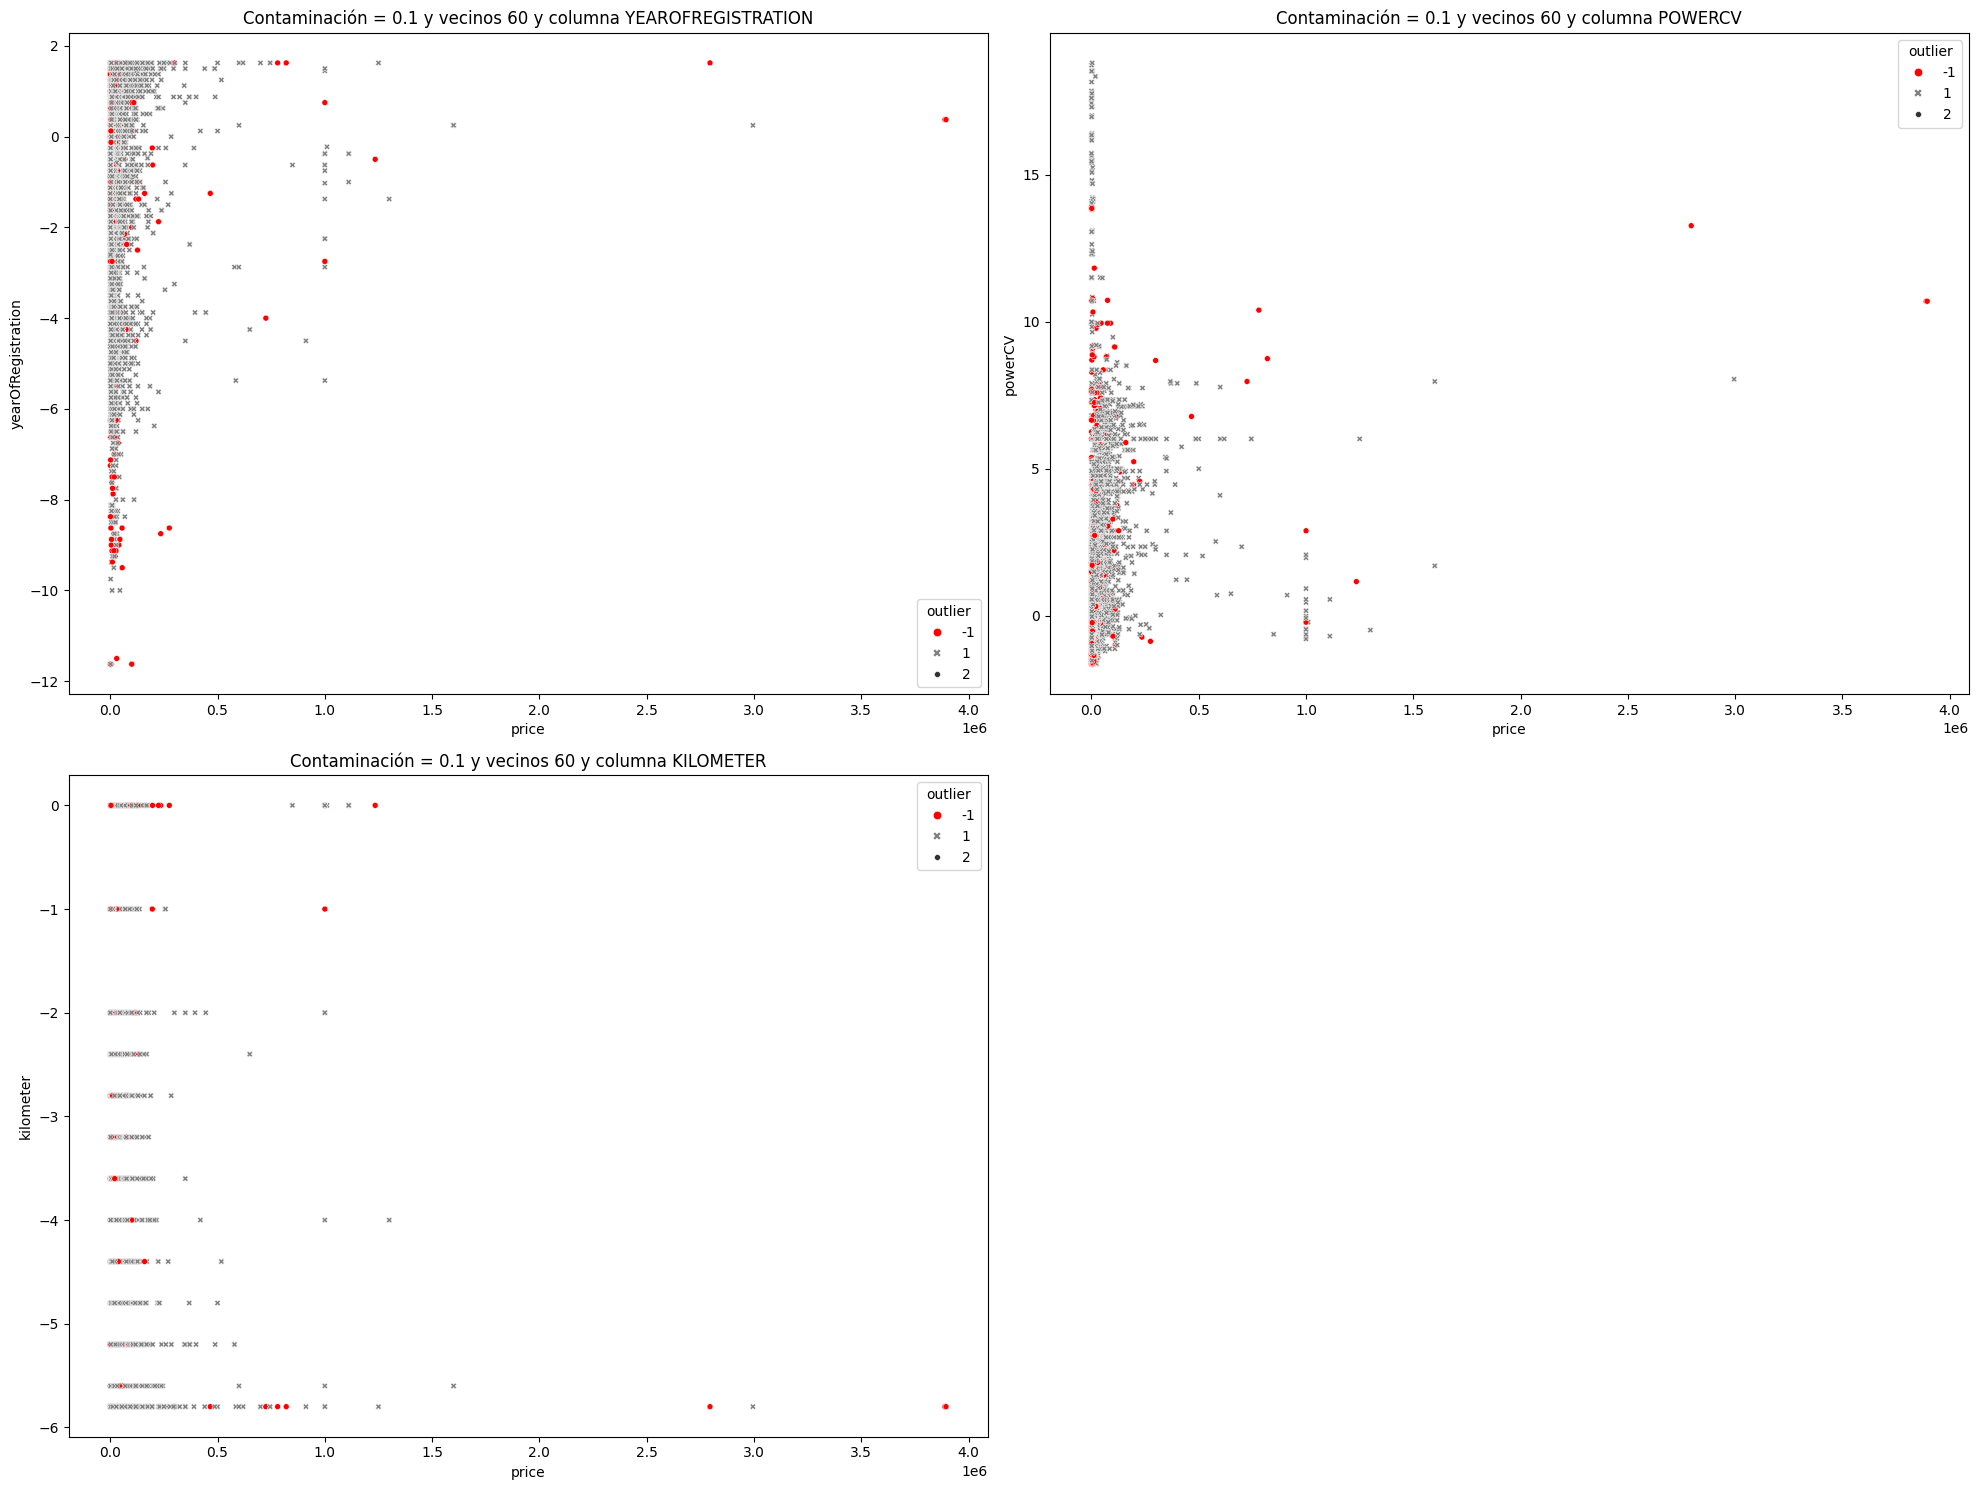

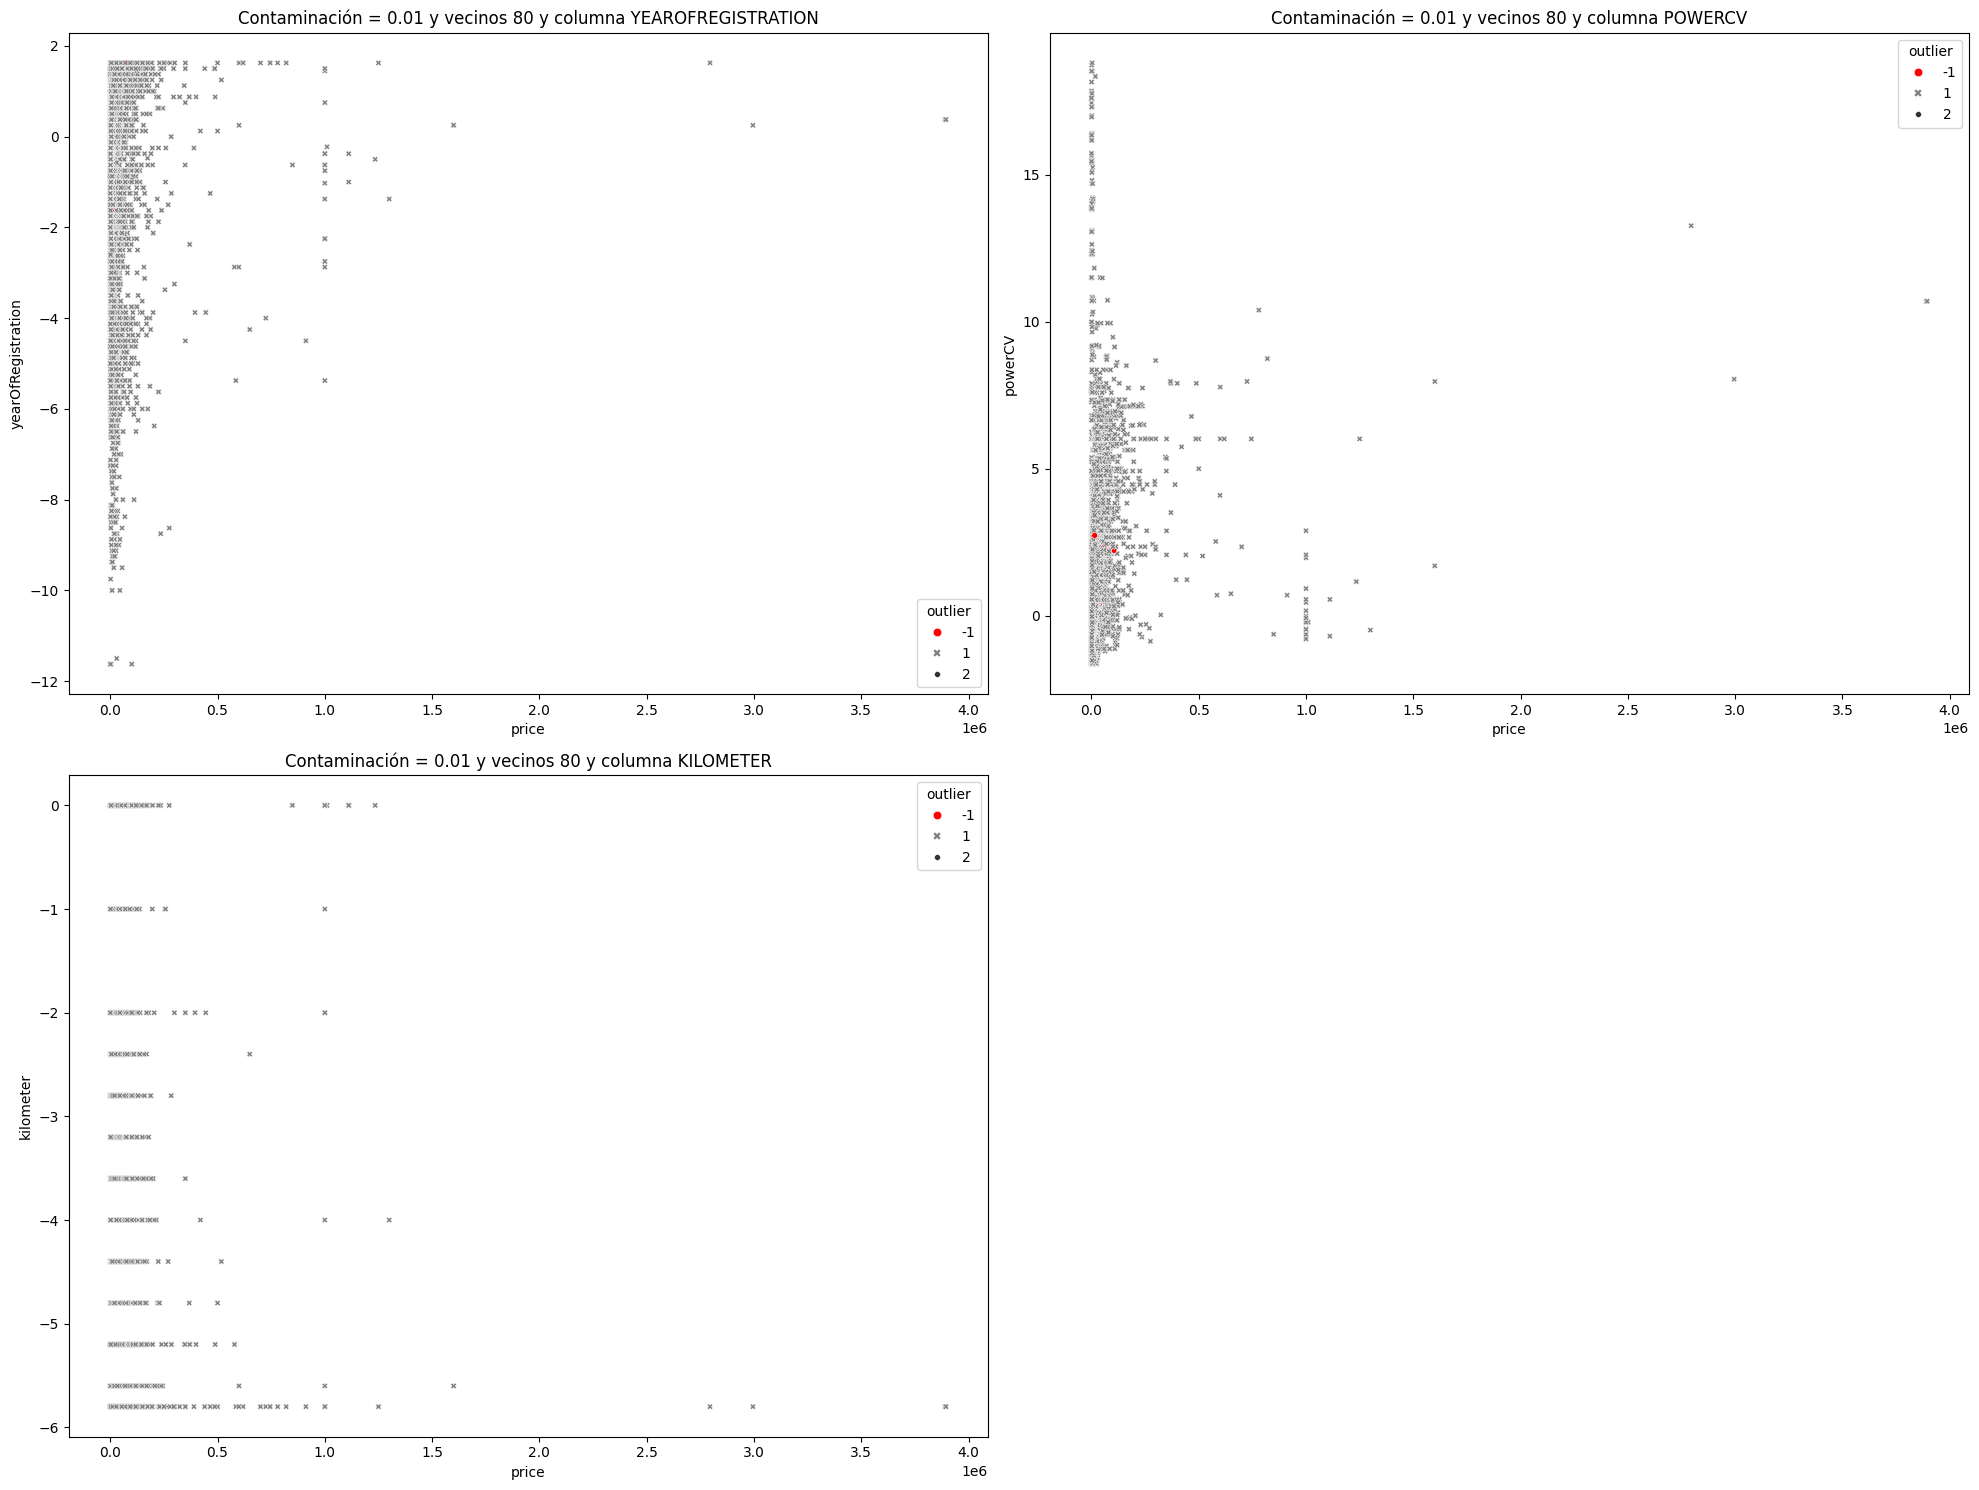

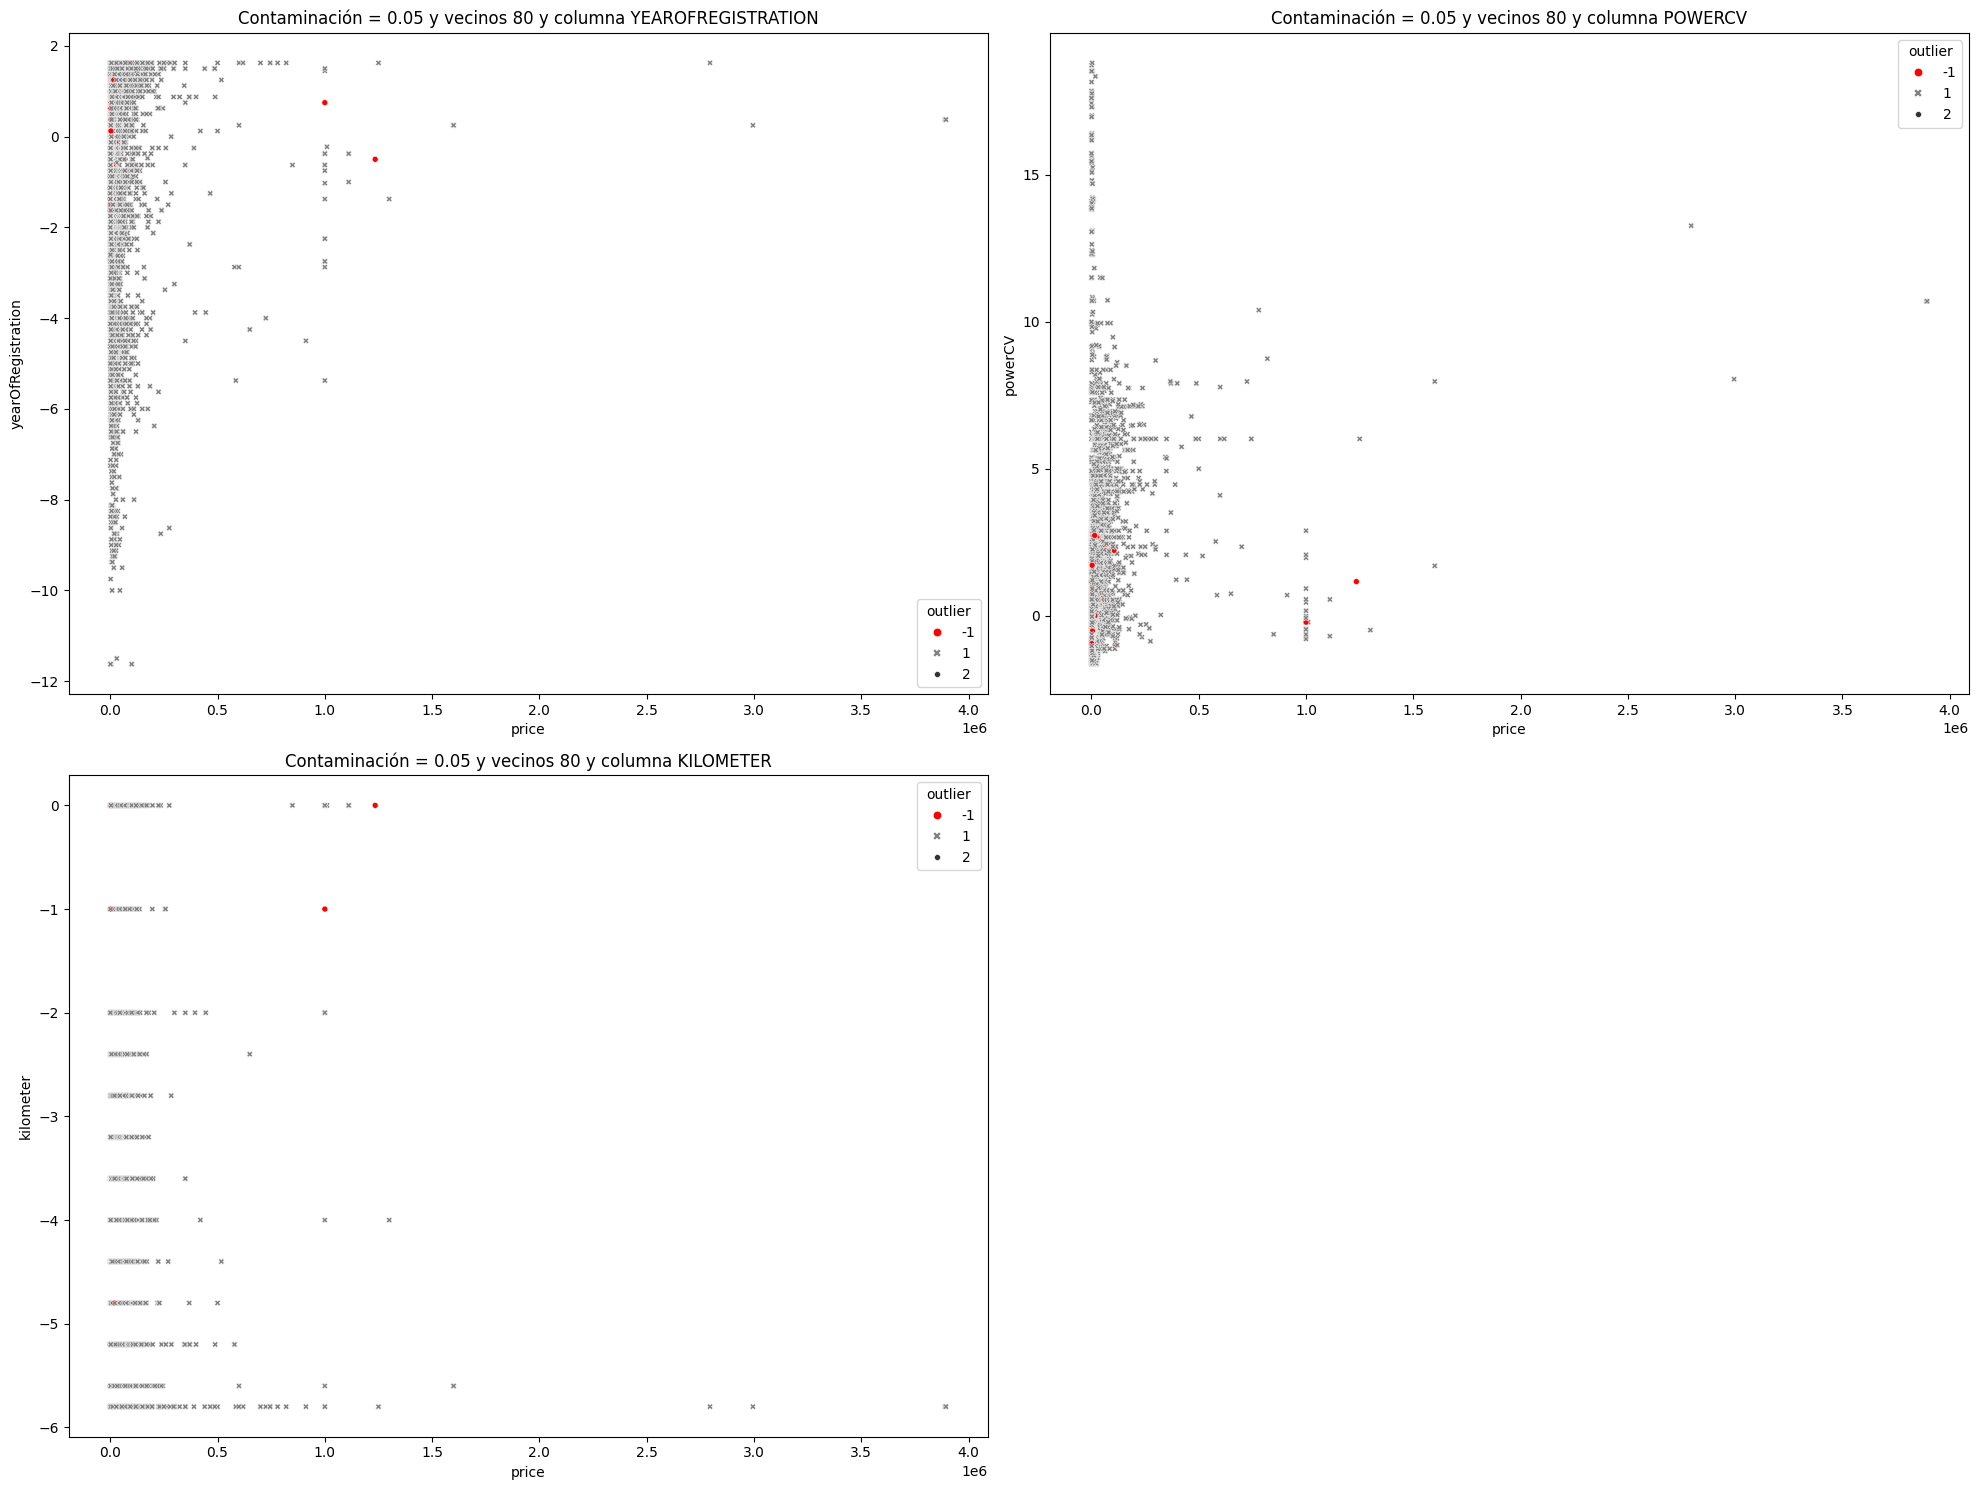

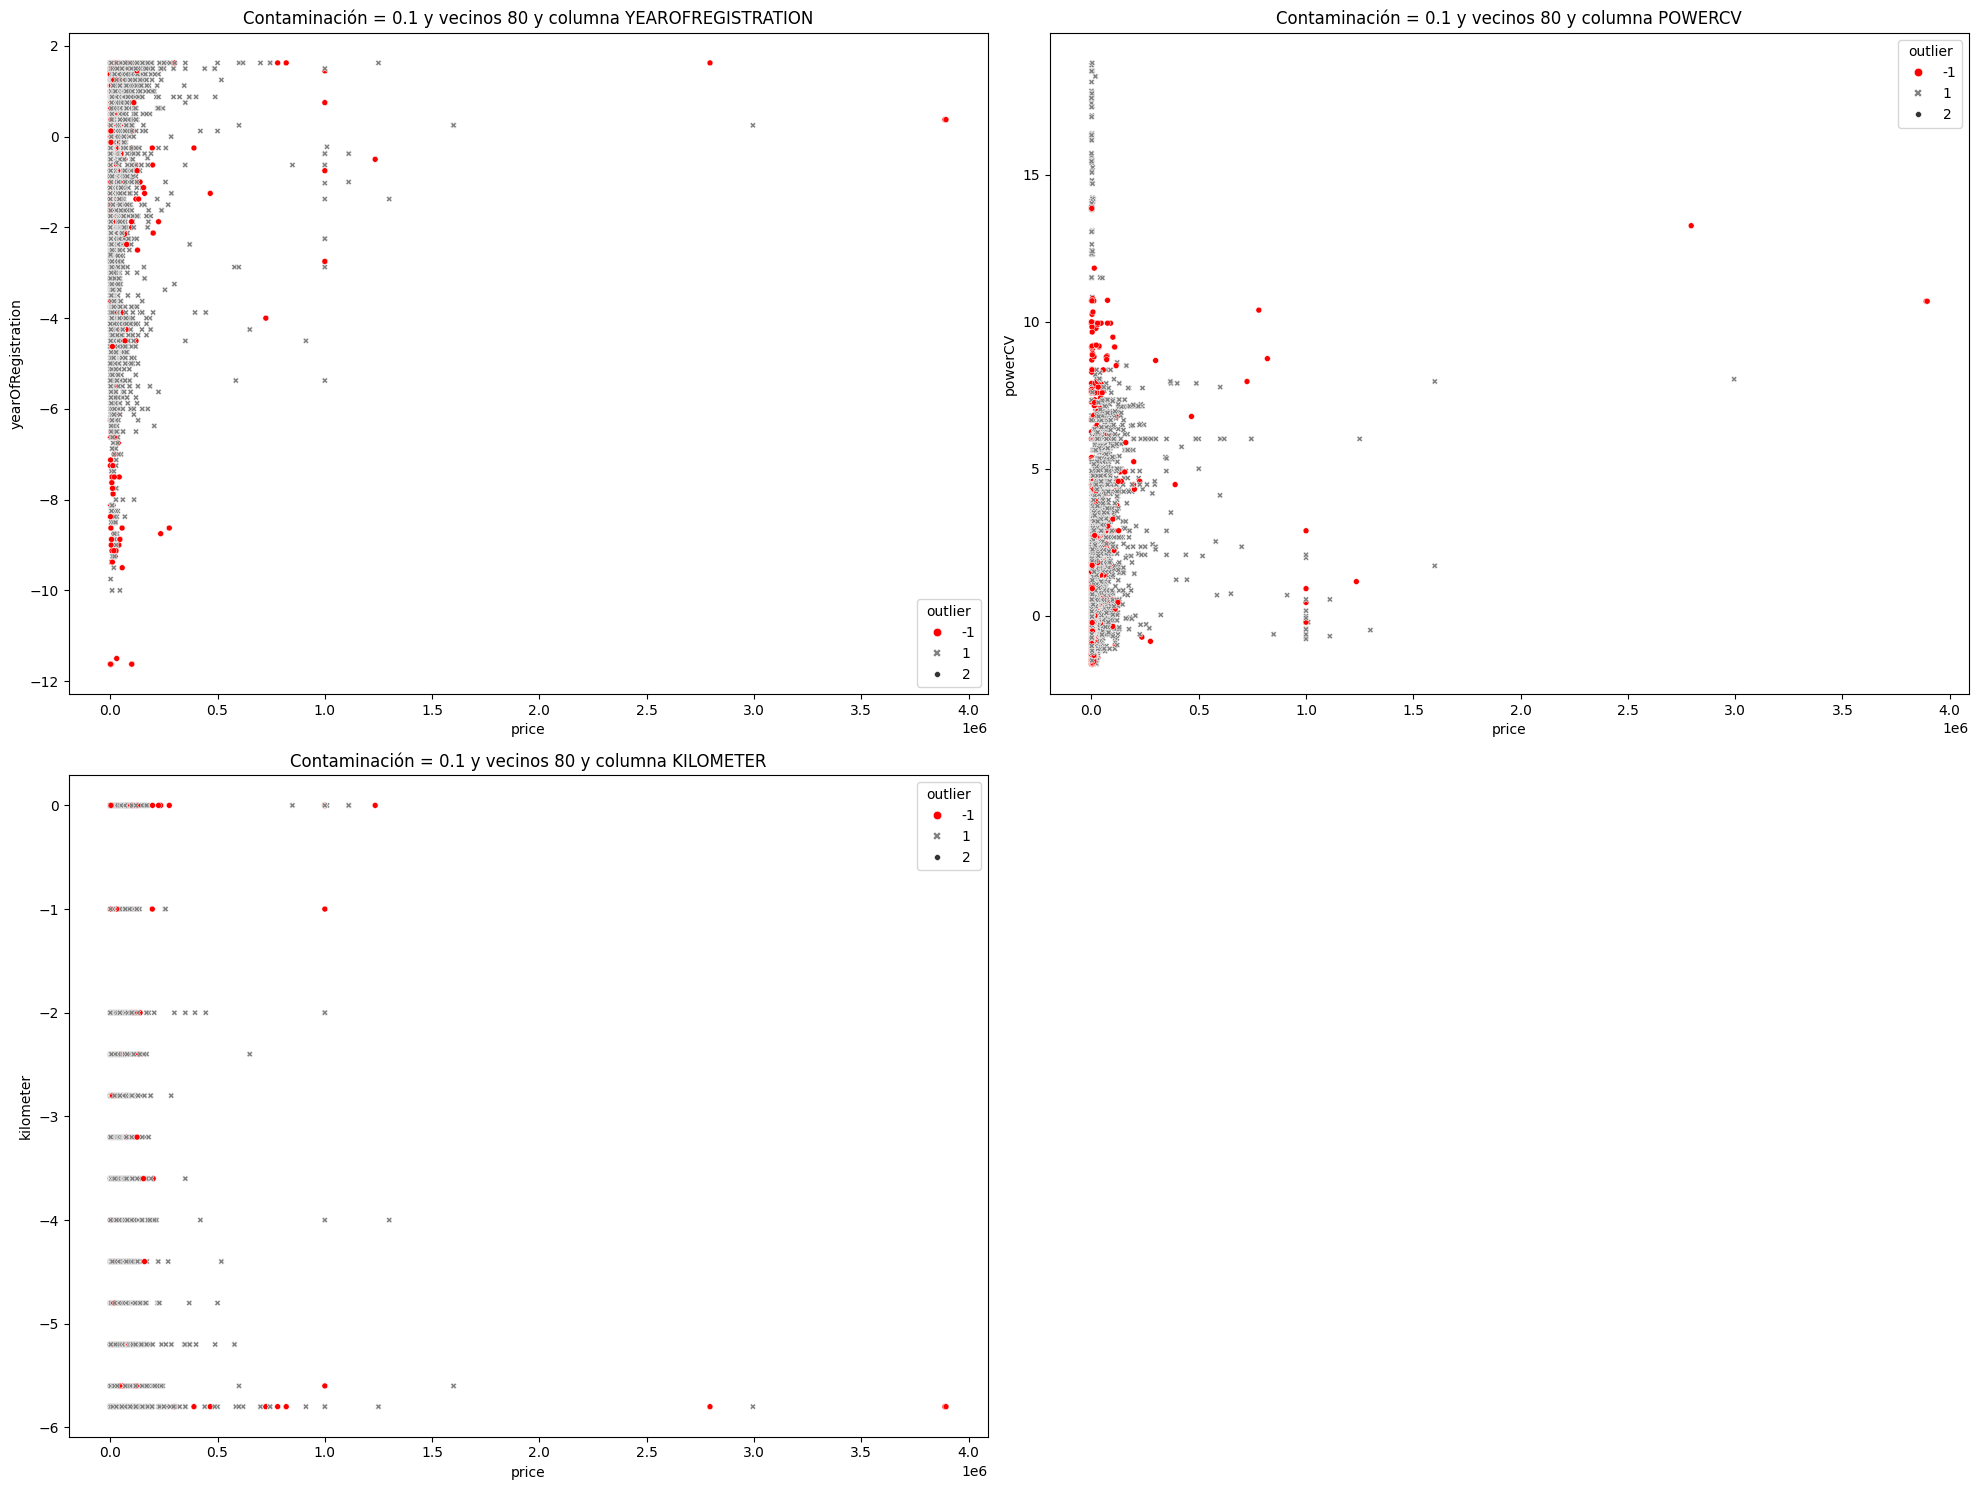

In [11]:
gestion_multi = GestionOutliersMultivariados(df)
gestion_multi.explorar_outliers_lof("price", indice_contaminacion, vecinos)

A simple vista y con diferentes combinaciones de número de vecinos no parece captar adecuadamente los outliers.

---

### Isolation forest

Probemos con el método `Isolation forest`

In [12]:
indice_contaminacion=[0.01, 0.05, 0.1]

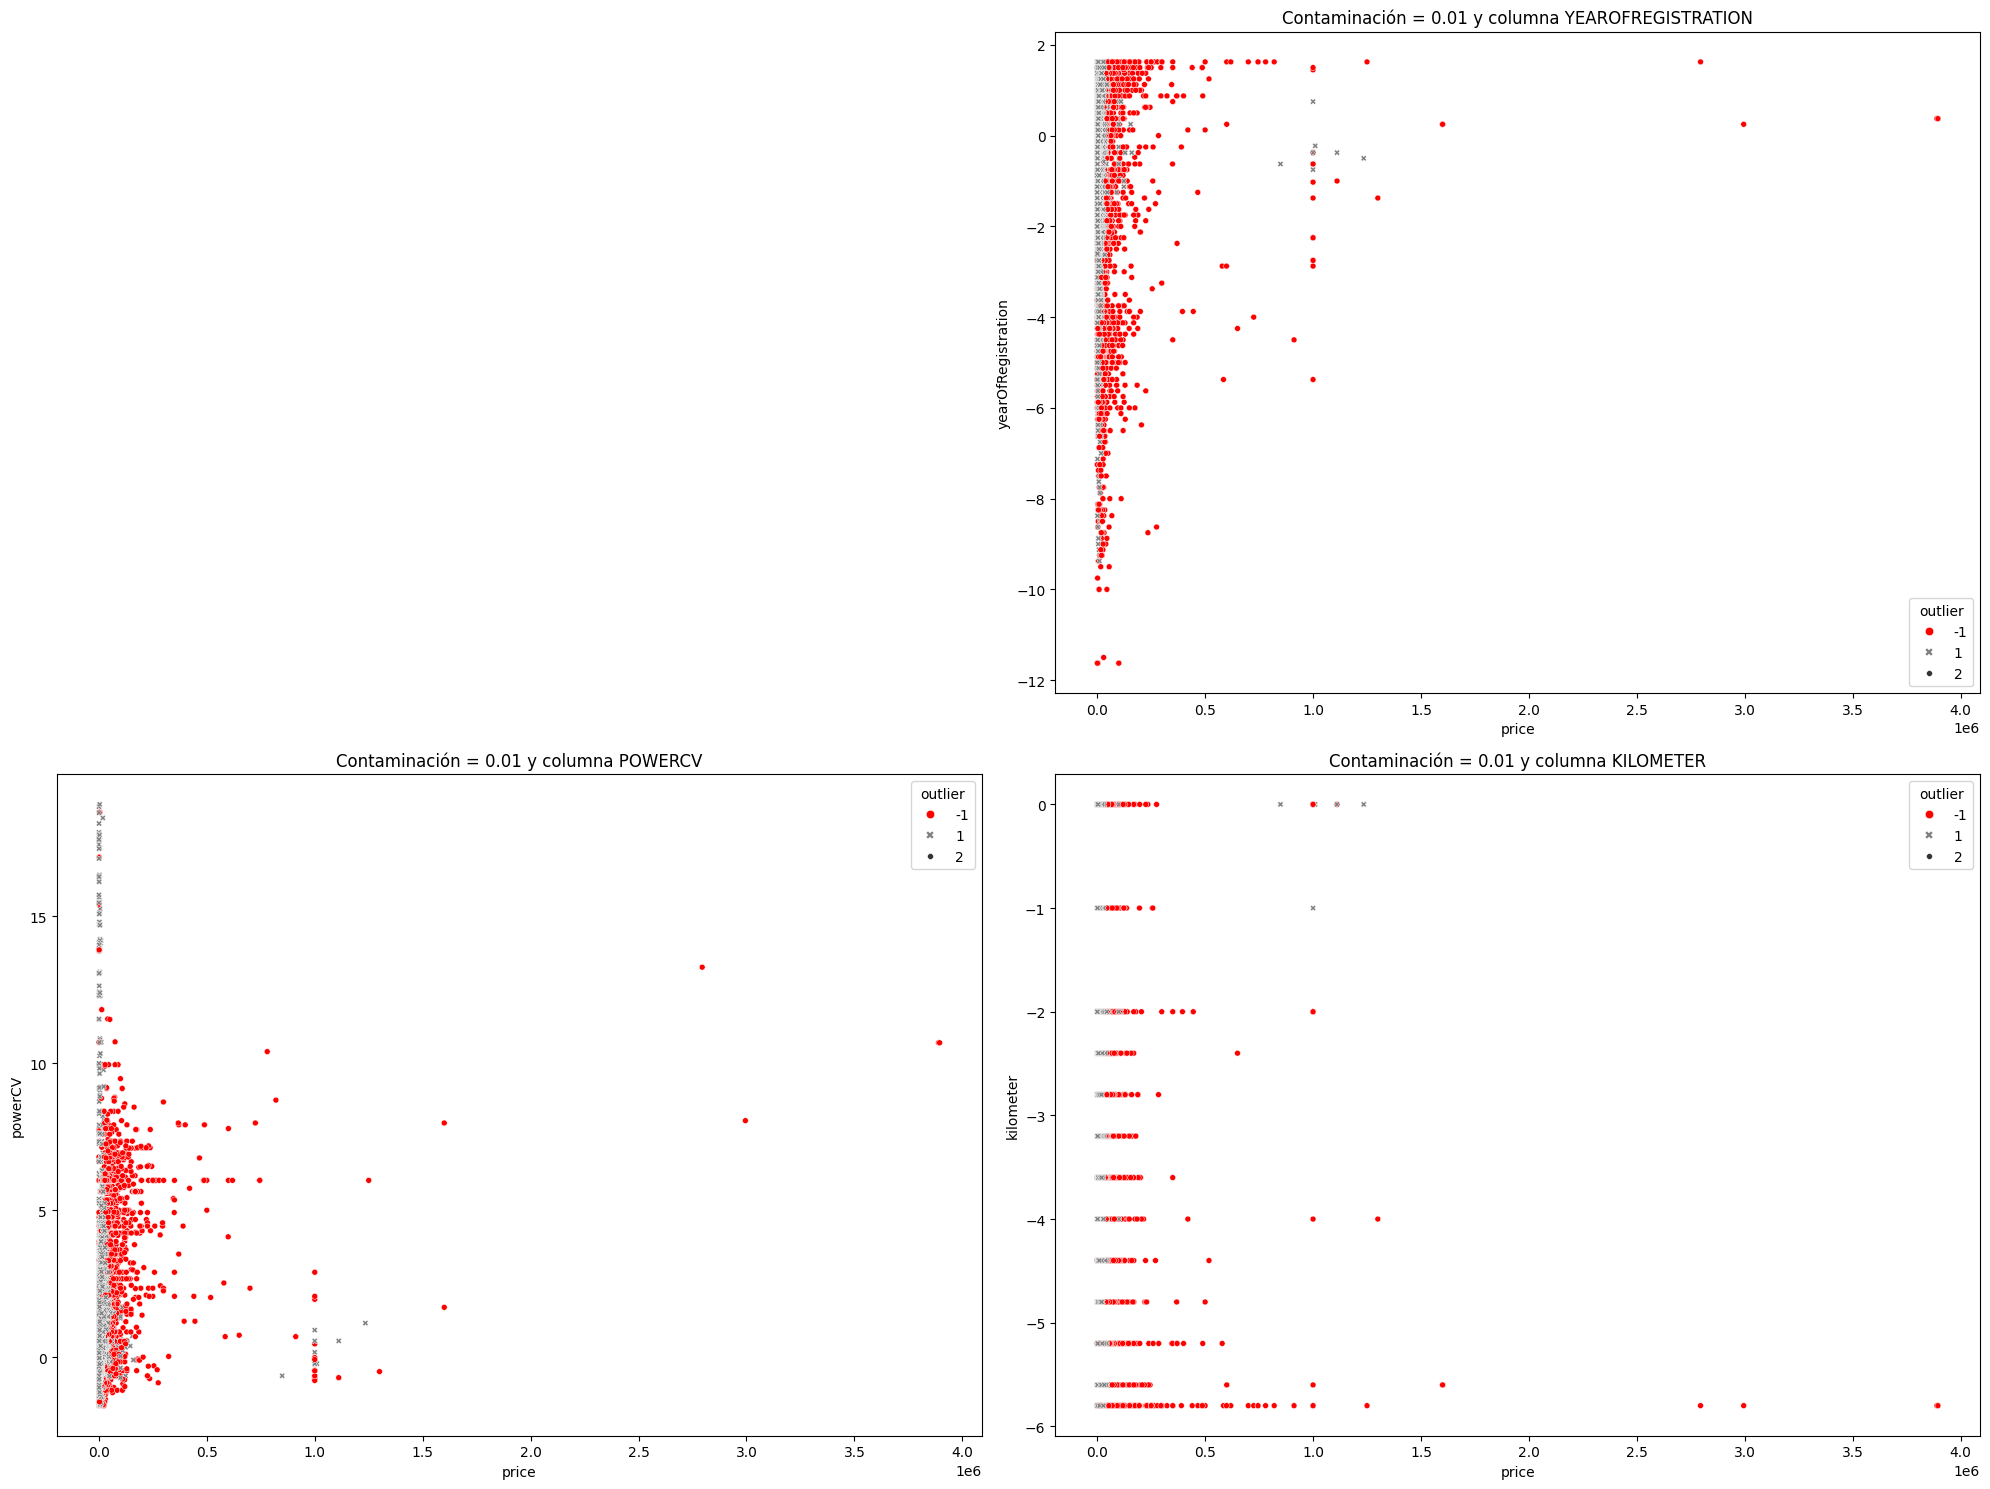

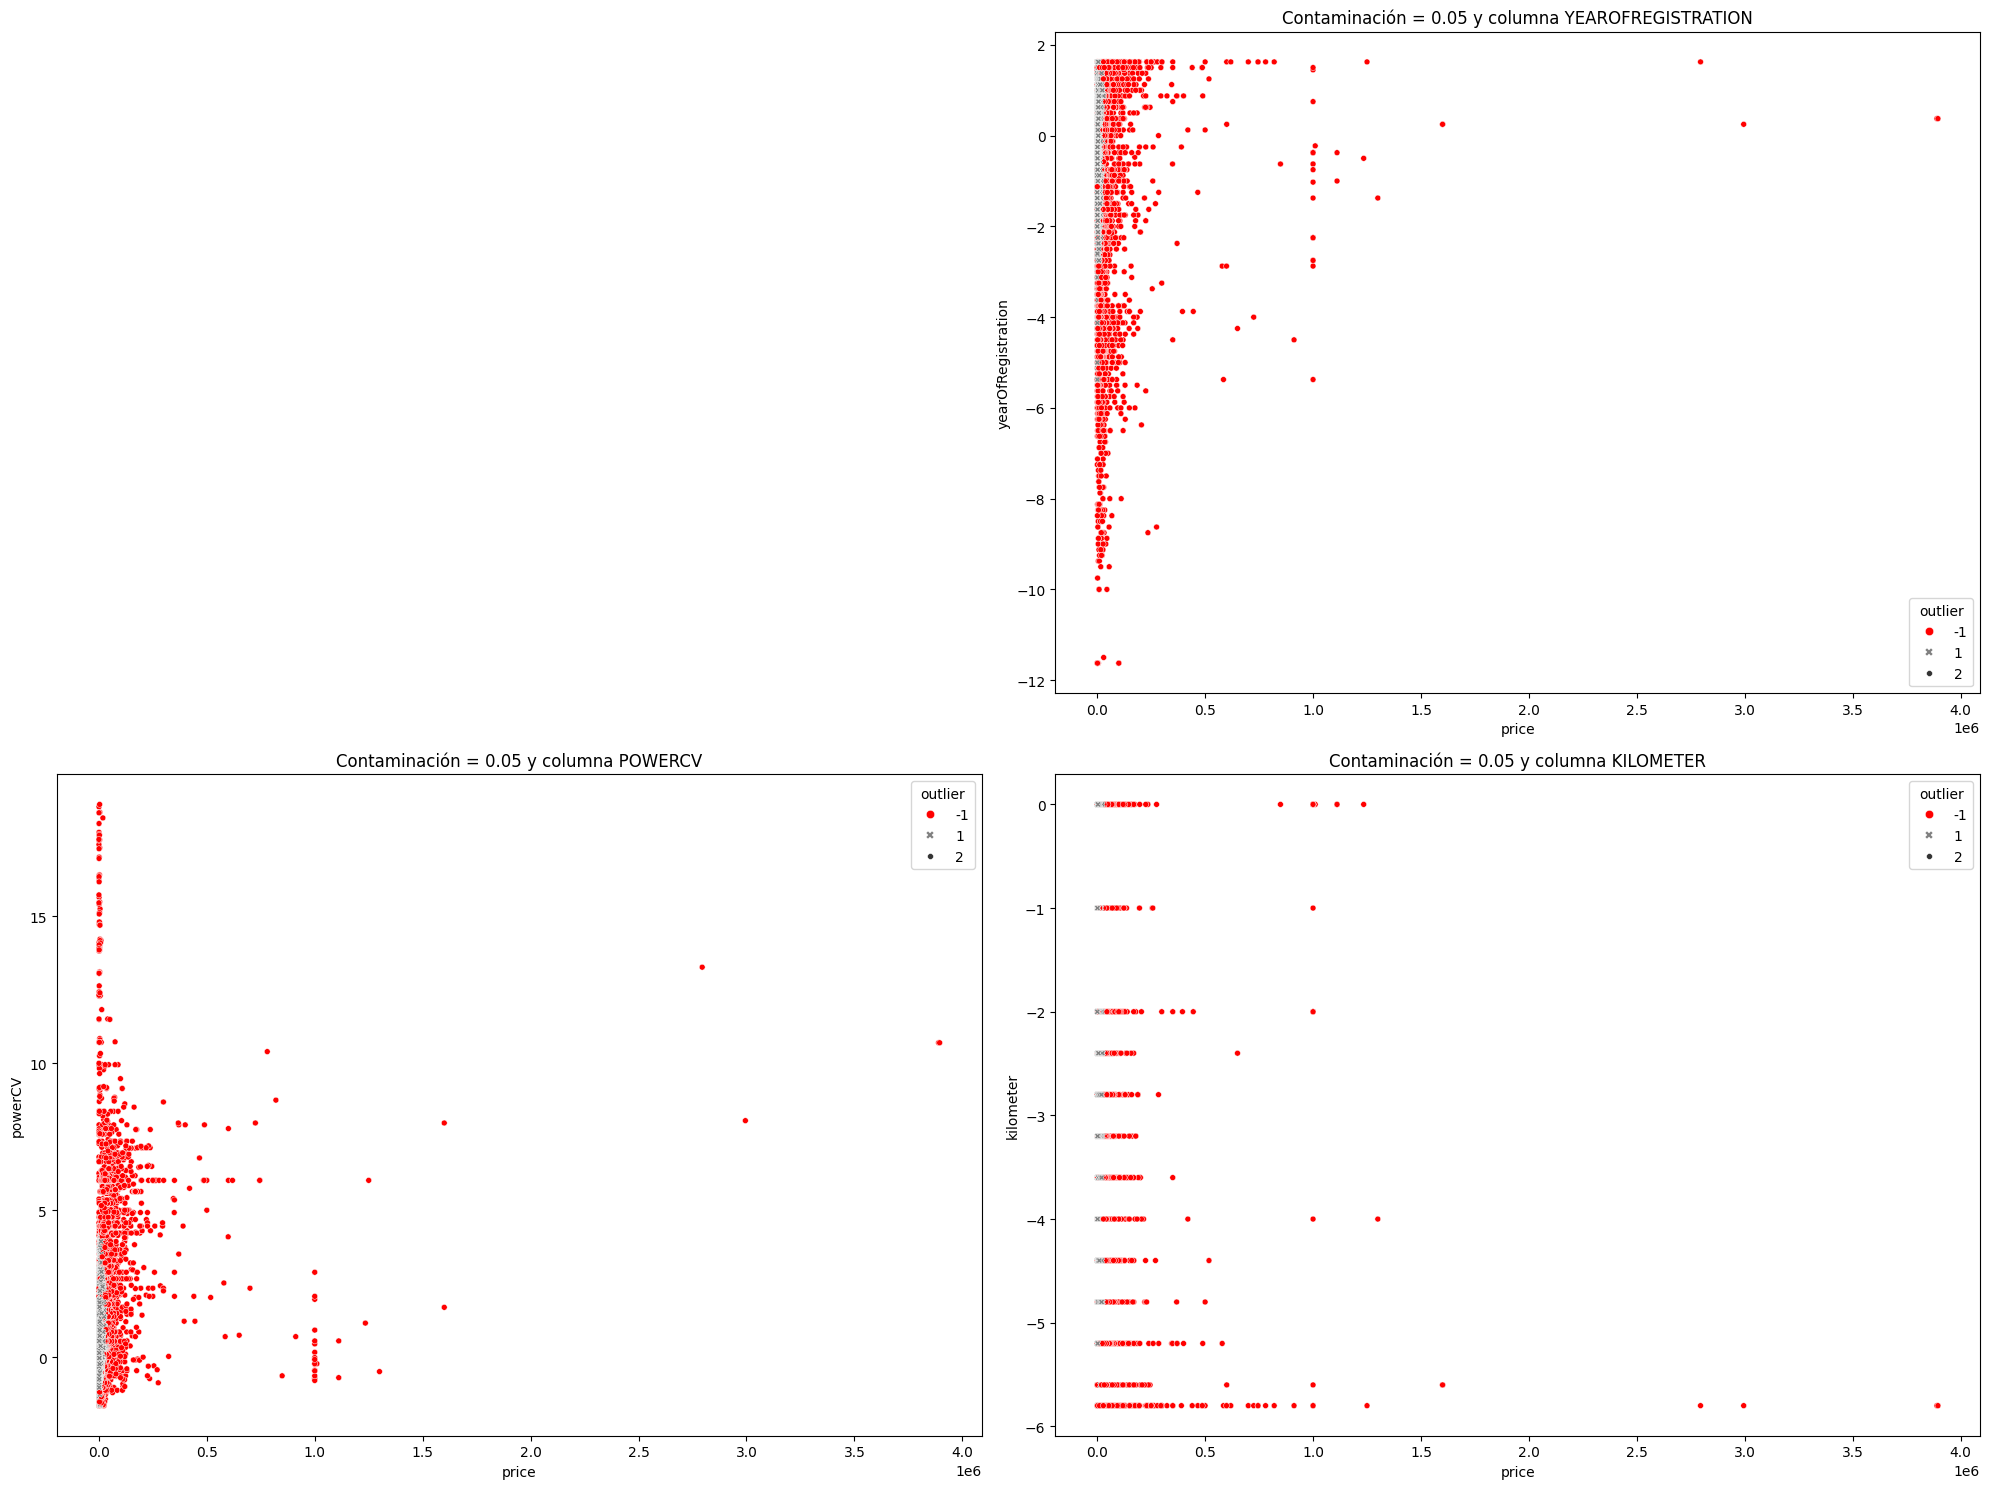

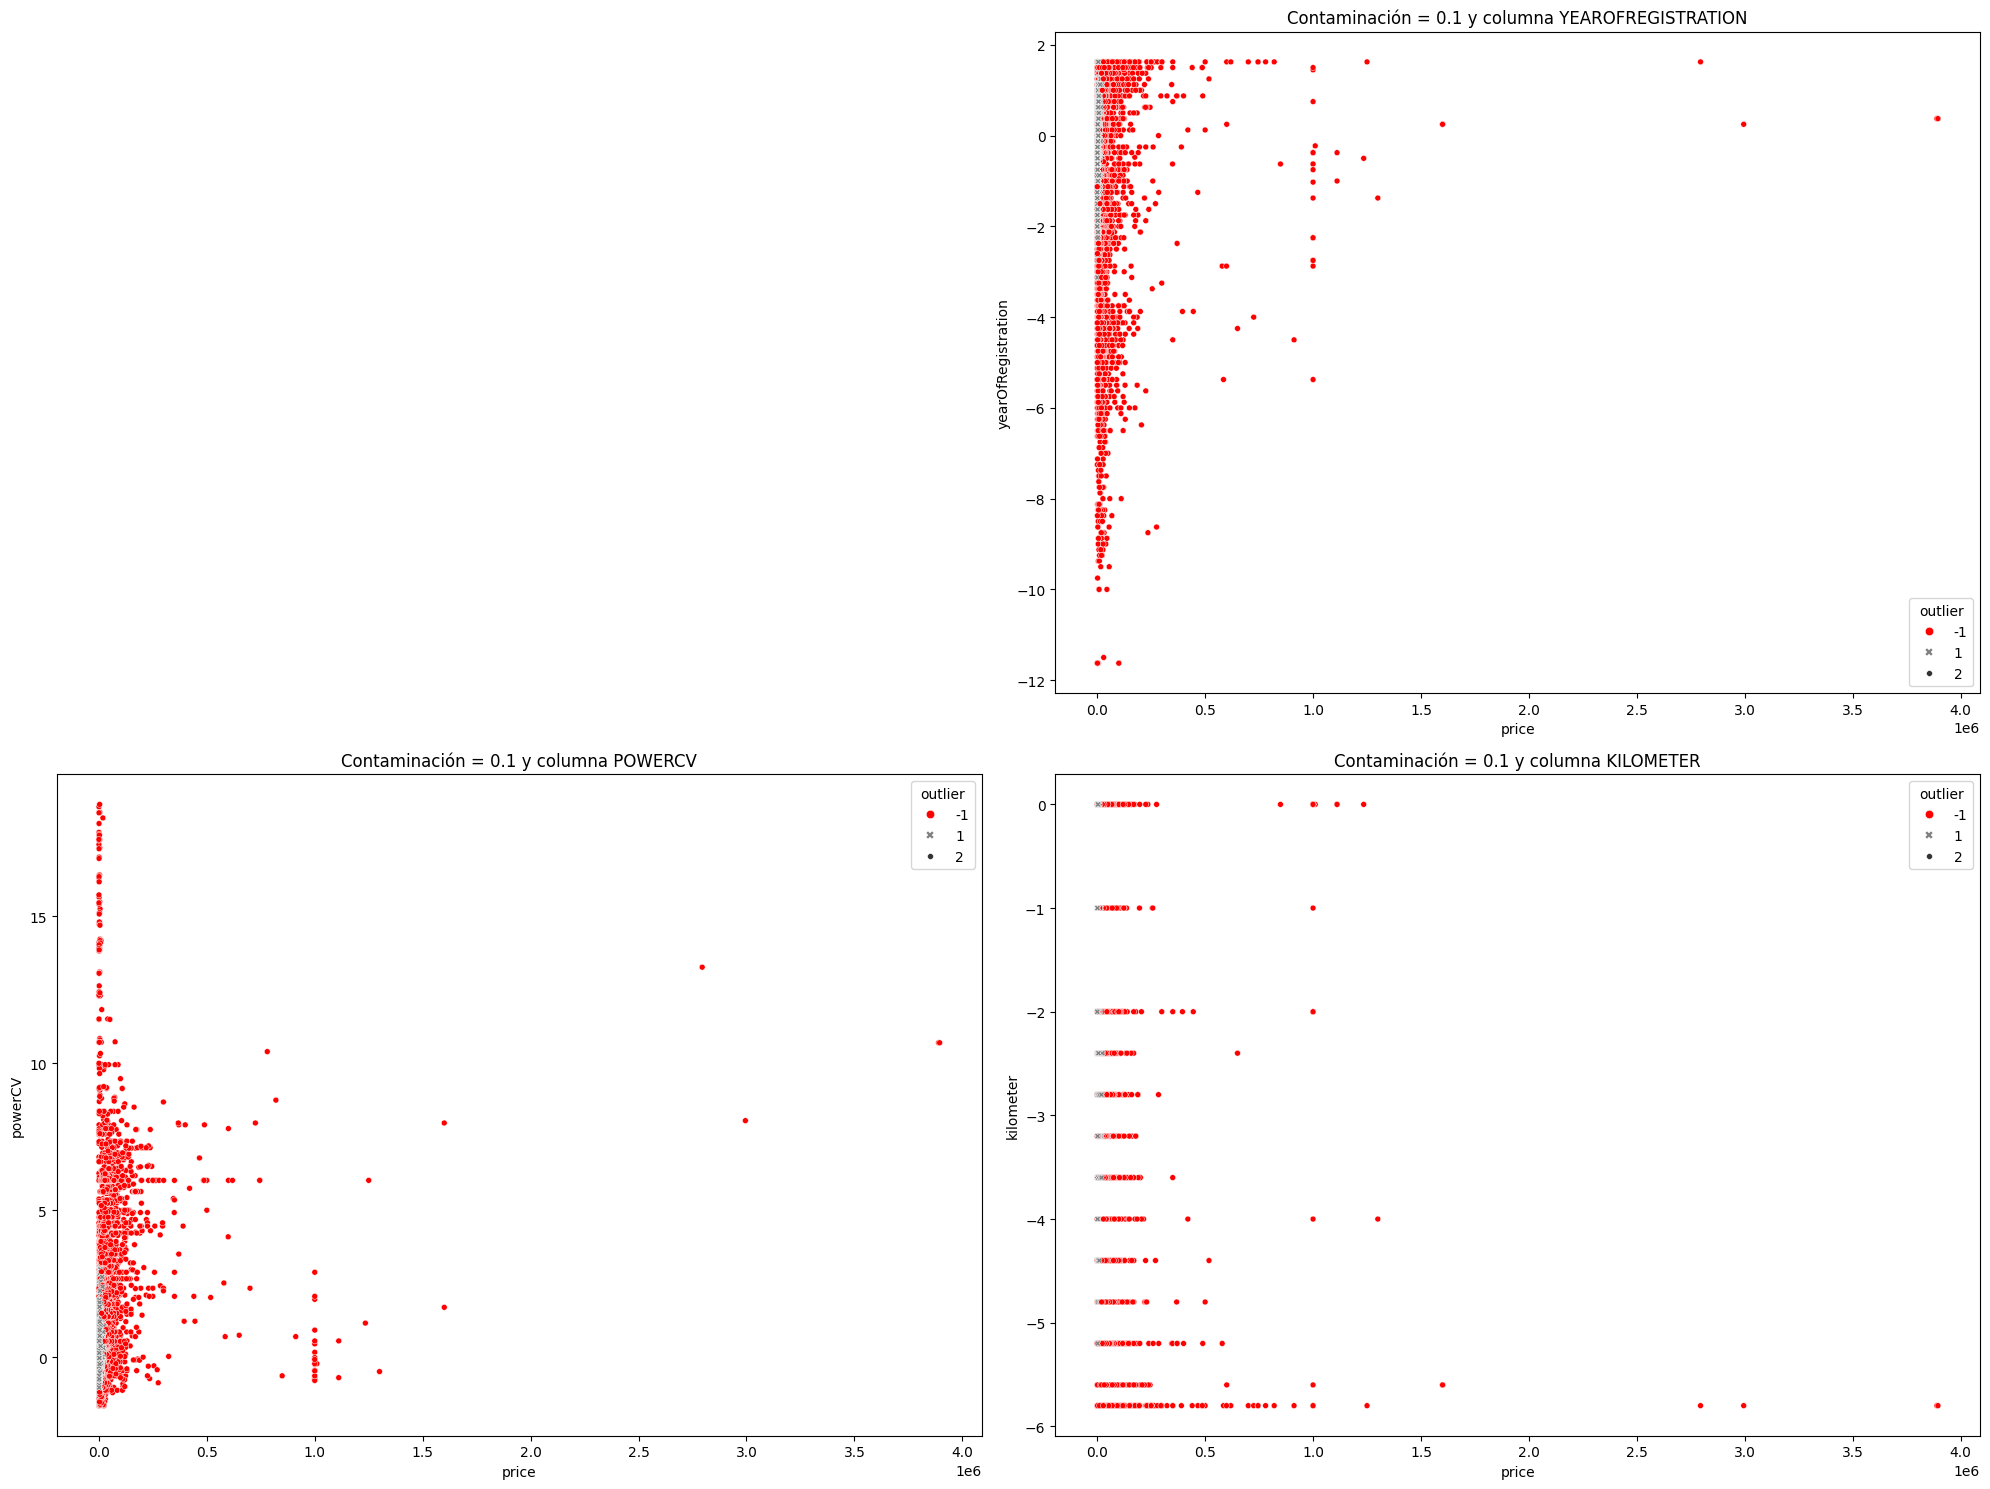

In [13]:
gestion_multi = GestionOutliersMultivariados(df)
gestion_multi.explorar_outliers_if("price", indice_contaminacion)

Vamos a quedarnos con un niver de contaminación de 0.01, ya que es capaz de captar los outliers sin penetrar demasiado en la estructura de los datos

In [14]:
df_outliers = gestion_multi.detectar_outliers_if(contaminacion=0.01)
df_outliers.head()

,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerCV,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,outlier
0,private,offer,480.0,test,desconocido,-1.250,manually,0.333333,golf,0.0,NaN,petrol,volkswagen,desconocido,1
1,private,offer,18300.0,test,coupe,1.000,manually,1.158730,desconocido,-1.0,5.0,diesel,audi,yes,1
2,private,offer,9800.0,test,suv,0.125,automatic,0.746032,grand,-1.0,8.0,diesel,jeep,desconocido,1
3,private,offer,1500.0,test,small car,-0.250,manually,-0.634921,golf,0.0,6.0,petrol,volkswagen,no,1
4,private,offer,3600.0,test,small car,0.625,manually,-0.730159,fabia,-2.4,7.0,diesel,skoda,no,1


In [15]:
df_outliers['outlier'].value_counts()

outlier
 1    331109
-1      3345
Name: count, dtype: int64

Vemos que efectivamente estaríamos tratando como outliers el 1% de los registros, como indica el nivel de contaminación

Finalmente imputamos los valores por la mediana, aunque podríamos considerar descartarlos

In [16]:
df_final = gestion_multi.imputar_outliers(data = df_outliers, metodo = "mediana")
df_final.head()

,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerCV,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage
0,private,offer,480.0,test,desconocido,-1.250,manually,0.333333,golf,0.0,NaN,petrol,volkswagen,desconocido
1,private,offer,18300.0,test,coupe,1.000,manually,1.158730,desconocido,-1.0,5.0,diesel,audi,yes
2,private,offer,9800.0,test,suv,0.125,automatic,0.746032,grand,-1.0,8.0,diesel,jeep,desconocido
3,private,offer,1500.0,test,small car,-0.250,manually,-0.634921,golf,0.0,6.0,petrol,volkswagen,no
4,private,offer,3600.0,test,small car,0.625,manually,-0.730159,fabia,-2.4,7.0,diesel,skoda,no


Guardamos el conjunto de datos

In [17]:
df_final.to_csv("datos/autorenew_knn_outliers.csv")

Nota: Conviene destacar que para un procedimiento más riguroso convendría llevar a cabo un análisis de diferentes combinaciones de contaminación y vecinos en los algoritmos de outliers multivariados ya que la inspección visual en muchas ocasiones no es suficiente. Sin embargo, dejamos esto para futuros pasos y refinar el funcionamiento de nuestros modelos.